In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import re
import seaborn as sns
from scipy.stats import pearsonr
from collections import Counter

In [64]:
home_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/'
home = '/net/mraid20/export/genie/LabData/Analyses/barakdan/Diet_Microbiome/'
PROBLEM = 'regression' # 'regression' or 'given_presence' or 'classification'
aggregate_features = True
aggregation = '_aggregated_features' if aggregate_features else ''

In [65]:
def read_results(df):
    output = []
    for col in df.columns:
        output.append(df[col])
    return tuple(output)

In [66]:
diet_mb = pd.read_pickle("/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_mb.pkl")
with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/my_lists.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
base_features, all_features, targets = loaded_lists

# Is this needed ?
# diet_mb.columns = diet_mb.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
# targets = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in targets]
# all_features = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in all_features]

diet_mb

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,...,fBin__94|gBin__448|sBin__654,fBin__94|gBin__449|sBin__656,fBin__95|gBin__450|sBin__659,fBin__96|gBin__457|sBin__669,fBin__97|gBin__462|sBin__676,fBin__97|gBin__462|sBin__678,fBin__99|gBin__469|sBin__687,Richness,Shannon_diversity,modified_HACK_top17_score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016416,0.000000,0.0,...,-4.000000,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.00000,189,3.75,558.526316
10K_1001201093,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013895,0.000000,0.0,...,-4.000000,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.00000,150,3.34,496.236842
10K_1002254441,0.0,0.0,0.0,0.0,0.0,0.081238,0.0,0.000000,0.000000,0.0,...,-3.228756,-4.0,-4.0,-4.0,-4.000000,-2.383721,-4.00000,250,4.25,488.500000
10K_1003113258,0.0,0.0,0.0,0.0,0.0,0.002048,0.0,0.008929,0.000000,0.0,...,-3.622636,-4.0,-4.0,-4.0,-4.000000,-3.806766,-4.00000,262,4.29,509.710526
10K_1007330152,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,-4.000000,-4.0,-4.0,-4.0,-4.000000,-1.937423,-2.98186,194,3.75,598.605263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,0.0,0.0,0.0,0.0,0.0,0.002401,0.0,0.000000,0.000000,0.0,...,-3.350185,-4.0,-4.0,-4.0,-4.000000,-3.832439,-3.78628,257,4.01,539.789474
10K_9998420917,0.0,0.0,0.0,0.0,0.0,0.019995,0.0,0.018783,0.000000,0.0,...,-3.309716,-4.0,-4.0,-4.0,-2.564519,-2.439687,-4.00000,264,4.25,538.368421
10K_9998635752,0.0,0.0,0.0,0.0,0.0,0.001607,0.0,0.011305,0.000000,0.0,...,-4.000000,-4.0,-4.0,-4.0,-4.000000,-2.996193,-4.00000,183,3.28,538.894737


In [68]:
len(targets)

724

Handle a case where diet features were aggregated into main categories

In [5]:
if aggregate_features:
    original_features = all_features.copy()  
    
    with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/food_categories.pkl', 'rb') as file1, \
         open(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/aggregated_feature_names_LGBM_abundance.pkl', 'rb') as file2:
        feature_to_category, categories = pickle.load(file1)
        all_features = pickle.load(file2).tolist()  # Overwrite the current features list with the aggregated features

category_nice_names = {
    'AlcoholicDrinks': 'Alcoholic Drinks',
    'fruitjuicesandsoftdrinks': 'Fruit Juices & Soft Drinks',
    'Beefveallambandothermeatproducts': 'Beef, Veal, Lamb & Other Meat',
    'Proccessedmeatproducts': 'Processed Meat Products',
    'Poultryanditsproducts': 'Poultry & Its Products',
    'bakedgoods': 'Baked Goods',
    'Bread': 'Bread',
    'Bread_wholewheat': 'Whole Wheat Bread',
    'FastFoods': 'Fast Foods',
    'Snacks': 'Snacks',
    'sweets': 'Sweets',
    'Cannedvegandfruits': 'Canned Vegetables & Fruits',
    'Fruits': 'Fruits',
    'MedOilandfats': 'Mediterranean Oils & Fats',
    'Vegetables': 'Vegetables',
    'Soupsandsauces': 'Soups & Sauces',
    'Cereals': 'Cereals',
    'Deepfriedfoods': 'Deep Fried Foods',
    'Drinks': 'Drinks',
    'sweetmilkproducts': 'Sweetened Milk Products',
    'Eggsandtheirproducts': 'Eggs & Their Products',
    'Fishandseafood': 'Fish & Seafood',
    'Hardcheese': 'Hard Cheese',
    'milkcreamcheeseandyogurts': 'Milk, Cream, Cheese & Yogurts',
    'Industrializedvegetarianfoodreadytoeat': 'Processed Vegetarian Food',
    'Oilsandfats': 'Oils & Fats',
    'Others': 'Other Foods',
    'PastaGrainsandSidedishes': 'Pasta, Grains & Side Dishes',
    'PastaGrainsandSidedishes_wholewheat': 'Whole Wheat Pasta & Grains',
    'Pulsesandproducts': 'Pulses & Their Products',
    'Spicesandherbs': 'Spices & Herbs',
    'Nutsseedsandproducts': 'Nuts, Seeds & Their Products'
}

all_features = [category_nice_names[cat] if cat in category_nice_names else cat for cat in all_features]

In [6]:
all_features

['Fast Foods',
 'Snacks',
 'Whole Wheat Pasta & Grains',
 'Fruit Juices & Soft Drinks',
 'Beef, Veal, Lamb & Other Meat',
 'Spices & Herbs',
 'Hard Cheese',
 'Baked Goods',
 'Fish & Seafood',
 'Drinks',
 'Deep Fried Foods',
 'Bread',
 'Sweets',
 'Vegetables',
 'Milk, Cream, Cheese & Yogurts',
 'Cereals',
 'Other Foods',
 'Processed Vegetarian Food',
 'Pasta, Grains & Side Dishes',
 'Sweetened Milk Products',
 'Alcoholic Drinks',
 'Mediterranean Oils & Fats',
 'Eggs & Their Products',
 'Pulses & Their Products',
 'Poultry & Its Products',
 'Soups & Sauces',
 'Whole Wheat Bread',
 'Processed Meat Products',
 'Canned Vegetables & Fruits',
 'Fruits',
 'Nuts, Seeds & Their Products',
 'Oils & Fats',
 'Anchovy',
 'Aperol',
 'Applesauce',
 'Beef_tongue',
 'Beet_Juice',
 'Brandy',
 'Broth_and_potatoes',
 'Cane_sugar',
 'Canned_tomatoes',
 'Canola_oil',
 'Chimichurri',
 'Chinese_orange',
 'Chocolate_Biscuit',
 'Chocolate_Milk',
 'Chocolate_chips',
 'Click',
 'Cooked_beets',
 'Cooked_eggplant',


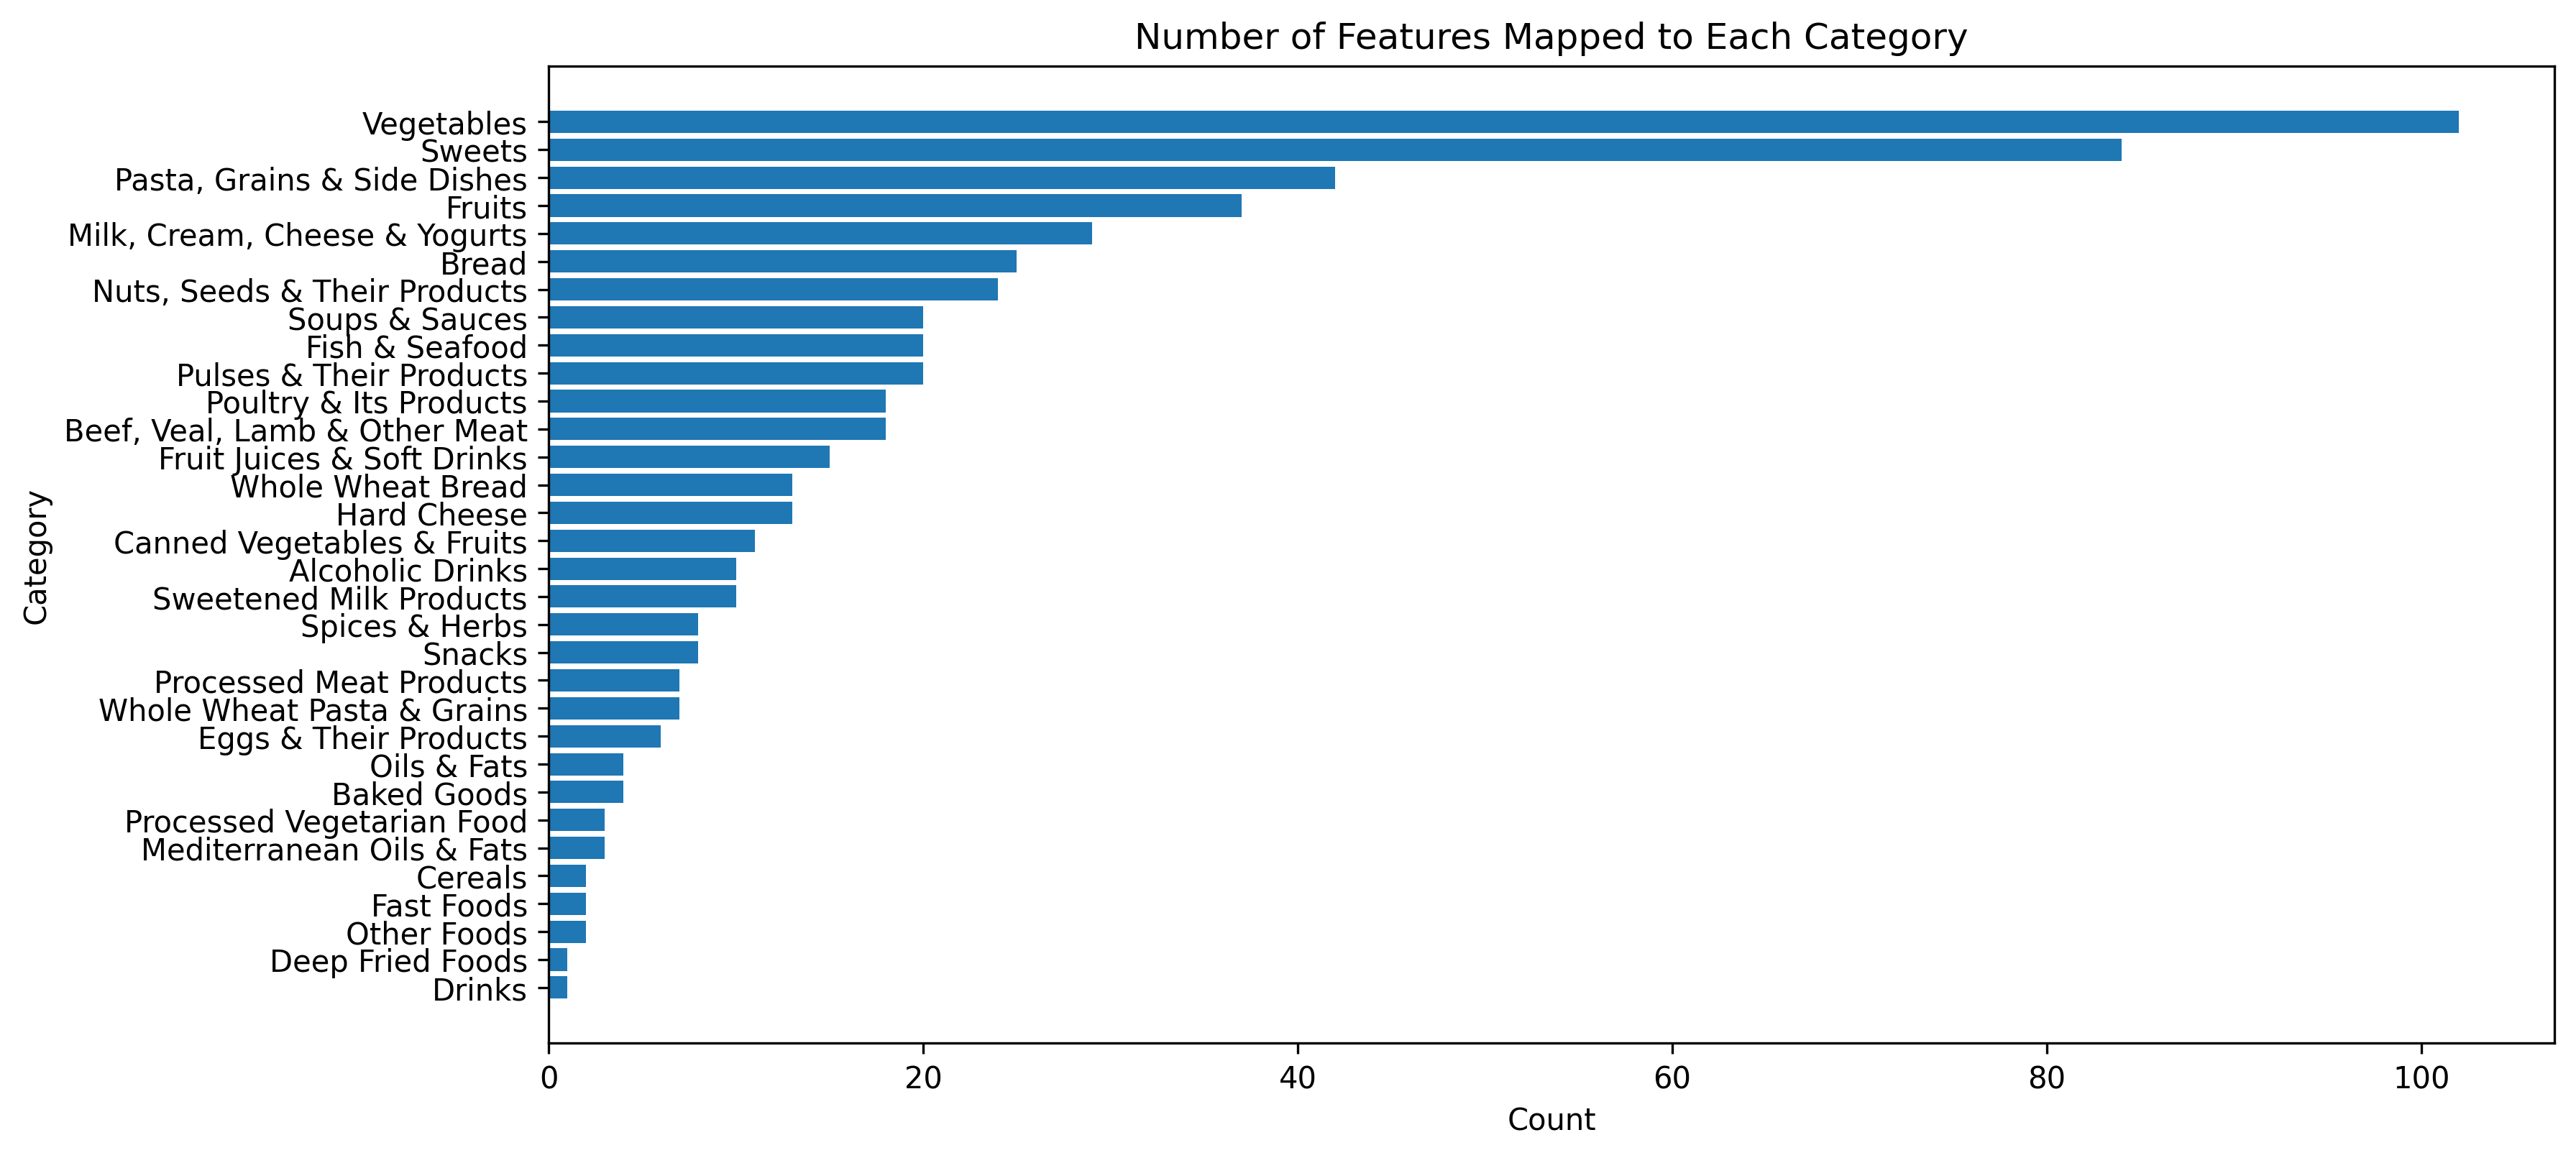

In [7]:
if aggregate_features:
    feature_to_category

    category_counts = Counter(feature_to_category.values())

    # Convert to DataFrame and display
    category_counts_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])
    category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)

    # Replace category names with their nicer names
    category_counts_df['Category'] = category_counts_df['Category'].map(category_nice_names)

    # Sort values
    category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)

    # Plot histogram
    plt.figure(figsize=(12, 6), dpi=300)
    plt.barh(category_counts_df['Category'], category_counts_df['Count'])
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.title('Number of Features Mapped to Each Category')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability

    plt.savefig(home+ f"figures/category_feature_count_histogram.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')

    # Show plot
    plt.show()

    # Other Foods is 'Brown_Sugar' and 'Sugar_substitute'.

    category_counts_df

In [8]:
all_features

['Fast Foods',
 'Snacks',
 'Whole Wheat Pasta & Grains',
 'Fruit Juices & Soft Drinks',
 'Beef, Veal, Lamb & Other Meat',
 'Spices & Herbs',
 'Hard Cheese',
 'Baked Goods',
 'Fish & Seafood',
 'Drinks',
 'Deep Fried Foods',
 'Bread',
 'Sweets',
 'Vegetables',
 'Milk, Cream, Cheese & Yogurts',
 'Cereals',
 'Other Foods',
 'Processed Vegetarian Food',
 'Pasta, Grains & Side Dishes',
 'Sweetened Milk Products',
 'Alcoholic Drinks',
 'Mediterranean Oils & Fats',
 'Eggs & Their Products',
 'Pulses & Their Products',
 'Poultry & Its Products',
 'Soups & Sauces',
 'Whole Wheat Bread',
 'Processed Meat Products',
 'Canned Vegetables & Fruits',
 'Fruits',
 'Nuts, Seeds & Their Products',
 'Oils & Fats',
 'Anchovy',
 'Aperol',
 'Applesauce',
 'Beef_tongue',
 'Beet_Juice',
 'Brandy',
 'Broth_and_potatoes',
 'Cane_sugar',
 'Canned_tomatoes',
 'Canola_oil',
 'Chimichurri',
 'Chinese_orange',
 'Chocolate_Biscuit',
 'Chocolate_Milk',
 'Chocolate_chips',
 'Click',
 'Cooked_beets',
 'Cooked_eggplant',


Summary of aggregation proccess

In [9]:
if aggregate_features:
    print(f"{len(original_features)} features were reduced to {len(all_features)} after aggregation.")
    print(f"Out of these {len(all_features)} features, first {len(categories)} are categorical and last {len(all_features) - len(categories)} are unmapped.")

715 features were reduced to 220 after aggregation.
Out of these 220 features, first 32 are categorical and last 188 are unmapped.


In [10]:
diversity_targets = ['Richness', 'Shannon_diversity']

In [11]:
# Filter non significant correlations from the permutations
with open(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/significant_targets.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
significant_targets = loaded_lists
significant_targets_indices = [targets.index(item) for item in significant_targets]

In [12]:
significant_targets[:6]

['fBin__100|gBin__473|sBin__693',
 'fBin__100|gBin__473|sBin__694',
 'fBin__100|gBin__477|sBin__698',
 'fBin__100|gBin__481|sBin__704',
 'fBin__100|gBin__481|sBin__705',
 'fBin__100|gBin__481|sBin__706']

In [13]:
mb_names = pd.read_pickle("/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/mb_names.pkl")

In [14]:
if PROBLEM != 'classification':
    results = pd.read_pickle(home_path + f"data/{PROBLEM}/output_ridge_div.pkl")
if PROBLEM == 'regression':
    ridge_div_scores, ridge_div_pvalues, ridge_div_coefs, ridge_div_preds, ridge_div_targets = read_results(results)
elif PROBLEM == 'given_presence':
    ridge_div_scores, ridge_div_pvalues, ridge_div_coefs, ridge_div_preds, ridge_div_targets, ridge_div_prevalence = read_results(results)

results = pd.read_pickle(home_path + f"data/{PROBLEM}/output_LGBM_abundance.pkl")
if PROBLEM == 'regression':
    lgbm_diet_scores, lgbm_diet_pvalues, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets = read_results(results)
elif PROBLEM == 'given_presence':
    lgbm_diet_scores, lgbm_diet_pvalues, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets, lgbm_diet_prevalence = read_results(results)
elif PROBLEM == 'classification':
    lgbm_diet_acc, lgbm_diet_auc, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets, lgbm_diet_pvalues = read_results(results)
    lgbm_diet_scores = lgbm_diet_auc

print(lgbm_diet_scores)


0      0.077883
1      0.091461
2     -0.002108
3      0.098086
4      0.036063
         ...   
720    0.014109
721    0.075310
722    0.034093
723    0.052125
724    0.094270
Name: 0, Length: 725, dtype: float64


In [15]:
lgbm_diet_scores = lgbm_diet_scores.loc[significant_targets_indices]

In [16]:
top_microbes = lgbm_diet_scores.sort_values(ascending=False)
top_microbes = top_microbes.head(16)
top_microbes

595    0.416845
46     0.410252
223    0.383439
34     0.351951
508    0.321826
32     0.319574
221    0.316319
309    0.299706
587    0.299517
237    0.298925
580    0.297099
201    0.286710
76     0.284811
611    0.268655
203    0.258070
282    0.256806
Name: 0, dtype: float64

In [17]:
# For summary plot
print(list(top_microbes.index))

[595, 46, 223, 34, 508, 32, 221, 309, 587, 237, 580, 201, 76, 611, 203, 282]


### SHAP Analyses

In [18]:
def mean_abs_shap(shap_orig_path, output_path, targets):
    mean_abs_shap = pd.Series(np.zeros(len(all_features)))
    print("Reading shap values...")
    shap_orig = pd.read_pickle(shap_orig_path)
    if PROBLEM != 'classification':
        shap_orig = shap_orig.iloc[:, 5:]
    print(shap_orig.isna().sum())
    print("shap_orig shape:", shap_orig.shape)
    for i in range(0, len(targets)):
    # # each row is a sample, each column is a feature, value is shap value
        print(i)
        shap = shap_orig.iloc[i]
        shap_df = pd.DataFrame(shap.tolist())
        to_concat = shap_df.abs().mean()
        to_concat = pd.DataFrame(to_concat)
        to_concat.columns = [str(i)]  # Specify your desired column name here
        mean_abs_shap = pd.concat([mean_abs_shap, to_concat], axis=1)
    mean_abs_shap = mean_abs_shap.iloc[:, 1:]
    mean_abs_shap.to_pickle(output_path)
    return mean_abs_shap

In [19]:
# mean_abs_shap_lgbm_abundance_regression = mean_abs_shap(
#     shap_orig_path = home_path + f"data/{PROBLEM}/output_SHAP_LGBM_abundance{aggregation}.pkl",
#     output_path = home_path + f"data/{PROBLEM}/mean_abs_shap_LGBM_abundance{aggregation}.pkl",
#     targets = targets
# )

# mean_abs_shap_lgbm_abundance = mean_abs_shap(home_path + f"data/{PROBLEM}/output_SHAP_LGBM_abundance.pkl", f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_LGBM_abundance.pkl", targets)
# mean_abs_shap_lgbm_div = mean_abs_shap(home_path + f"data/{PROBLEM}/output_SHAP_LGBM_div.pkl", f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_LGBM_div.pkl", diversity_targets)
# mean_abs_shap_ridge_div = mean_abs_shap(home_path + f"data/{PROBLEM}/output_SHAP_ridge_div.pkl", f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_ridge_div.pkl", diversity_targets)

In [20]:
# for i in range(0, 2):
# # each row is a sample, each column is a feature, value is shap value
#     shap_richness = shap_ridge_div.iloc[0] 
#     shap_shannon = shap_ridge_div.iloc[1]

In [21]:
microbe_name_list = []

for target in significant_targets:
    microbe_name_list.append(mb_names.loc[target, 'species_new'])

score_name = 'Pearson Correlation' if PROBLEM != 'classification' else 'AUC'
# Create the DataFrame with numerical indices
map_df = pd.DataFrame({
    'Microbe_Name': microbe_name_list,
    score_name: list(lgbm_diet_scores),
    'targets': significant_targets
}, index=lgbm_diet_scores.index)
# df.loc[df['Microbe_Name'] == 'Clostridium sp900539375']
map_df = map_df.sort_values(by=[score_name], ascending=False)
map_df.head(16)

,Microbe_Name,Pearson Correlation,targets
595,Lawsonibacter sp900066825,0.416845,fBin__541|gBin__2137|sBin__3295
46,Streptococcus thermophilus,0.410252,fBin__187|gBin__748|sBin__1116
223,UBA11774 sp003507655,0.383439,fBin__367|gBin__1458|sBin__2166
34,Bifidobacterium longum,0.351951,fBin__121|gBin__572|sBin__848
508,Angelakisella sp900547385,0.321826,fBin__537|gBin__2032|sBin__3102
32,Bifidobacterium adolescentis,0.319574,fBin__121|gBin__568|sBin__842
221,Pararoseburia lenta,0.316319,fBin__367|gBin__1456|sBin__2163
309,Blautia_A sp000436615,0.299706,fBin__376|gBin__1557|sBin__2330
587,Intestinimonas butyriciproducens,0.299517,fBin__541|gBin__2127|sBin__3277
237,Agathobacter rectalis,0.298925,fBin__367|gBin__1470|sBin__2185


In [22]:
map_df.loc[map_df['Microbe_Name'].str.contains('lacto')]

,Microbe_Name,Pearson Correlation,targets
43,Ligilactobacillus ruminis,0.194967,fBin__159|gBin__682|sBin__1042


In [23]:
# map_df.to_csv(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/map_df.csv', index=True)

In [24]:
print(map_df.loc[map_df['Microbe_Name'].str.contains('Lactobacillus|L\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Bifidobacterium|B\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Streptococcus|S\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Enterococcus|E\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Bacillus|B\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Saccharomyces|S\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Pediococcus|P\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Leuconostoc|L\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Weissella|W\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Propionibacterium|P\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Akkermansia|A\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Faecalibacterium|F\\. ')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Lactococcus lactis')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Clostridium butyricum')])
print(map_df.loc[map_df['Microbe_Name'].str.contains('Bacteroides')])


Empty DataFrame
Columns: [Microbe_Name, Pearson Correlation, targets]
Index: []
                         Microbe_Name  Pearson Correlation  \
34             Bifidobacterium longum             0.351951   
32       Bifidobacterium adolescentis             0.319574   
33            Bifidobacterium bifidum             0.253809   
30        Bifidobacterium catenulatum             0.231444   
28          Bifidobacterium angulatum             0.218601   
27         Bifidobacterium animalis_B             0.161209   
29  Bifidobacterium pseudocatenulatum             0.153284   
31        Bifidobacterium ruminantium             0.063527   

                          targets  
34  fBin__121|gBin__572|sBin__848  
32  fBin__121|gBin__568|sBin__842  
33  fBin__121|gBin__571|sBin__846  
30  fBin__121|gBin__568|sBin__840  
28  fBin__121|gBin__566|sBin__836  
27  fBin__121|gBin__564|sBin__834  
29  fBin__121|gBin__568|sBin__838  
31  fBin__121|gBin__568|sBin__841  
                     Microbe_Name  Pe

In [25]:
sorted(list(map_df["Microbe_Name"]))

['51-20 sp001917175',
 'Acetatifactor acetigignens',
 'Acetatifactor intestinalis',
 'Acetatifactor sp900755865',
 'Acetatifactor sp900760705',
 'Acetatifactor sp900771995',
 'Acetatifactor sp900772845',
 'Acidaminococcus intestini',
 'Acutalibacter ornithocaccae',
 'Adlercreutzia equolifaciens',
 'Adlercreutzia rubneri',
 'Agathobacter faecis',
 'Agathobacter rectalis',
 'Agathobacter sp000434275',
 'Agathobacter sp900546625',
 'Agathobacter sp900550545',
 'Agathobacter sp900552085',
 'Agathobacter sp905209075',
 'Agathobaculum ammoniilyticum',
 'Agathobaculum butyriciproducens',
 'Agathobaculum hominis',
 'Agathobaculum sp900544475',
 'Akkermansia massiliensis',
 'Akkermansia muciniphila',
 'Alangreenwoodia sp905206455',
 'Alectryocaccomicrobium excrementavium',
 'Alectryocaccomicrobium faecavium',
 'Alistipes avistercoris',
 'Alistipes communis',
 'Alistipes dispar',
 'Alistipes finegoldii',
 'Alistipes merdipullorum',
 'Alistipes onderdonkii',
 'Alistipes putredinis',
 'Alistipes s

#### What features predict the highly predicted microbes in ridge, according to linear coefficients?

In [26]:
if not aggregate_features:
    if PROBLEM != 'classification':
        top_coefs_richness = pd.Series(ridge_div_coefs[0]).abs().sort_values(ascending=False)[0:20].index
        print("Top 20 Coefficients for Richness:\n", top_coefs_richness)

        top_fnames_richness = pd.Series(all_features).loc[top_coefs_richness]
        print("Top 20 Feature Names for Richness:\n", top_fnames_richness)

        top_coefs_shannon = pd.Series(ridge_div_coefs[1]).abs().sort_values(ascending=False)[0:20].index
        print("Top 20 Coefficients for Shannon Index:\n", top_coefs_shannon)

        top_fnames_shannon = pd.Series(all_features).loc[top_coefs_shannon]
        print("Top 20 Feature Names for Shannon Index:\n", top_fnames_shannon)

#### What are the highest mean abs shap values?

In [27]:
# mean_abs_shap_ridge_div = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_ridge_div.pkl")
# # mean_abs_shap_ridge_abundance = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_ridge_abundance.pkl")
# mean_abs_shap_lgbm_div = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_LGBM_div.pkl")
mean_abs_shap_lgbm_abundance_agg_classification = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/mean_abs_shap_LGBM_abundance_aggregated_features.pkl")
mean_abs_shap_lgbm_abundance_agg_given = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/given_presence/mean_abs_shap_LGBM_abundance_aggregated_features.pkl")
mean_abs_shap_lgbm_abundance_agg_regression = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/regression/mean_abs_shap_LGBM_abundance_aggregated_features.pkl")
mean_abs_shap_lgbm_abundance = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/regression/mean_abs_shap_LGBM_abundance.pkl")

In [28]:
mean_abs_shap_lgbm_abundance_agg_regression

,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,724
0,0.000011,0.000089,0.000353,0.000048,0.000061,0.000110,0.000046,0.000740,0.000015,0.000142,...,0.000100,0.000067,0.000110,0.000079,0.000022,0.000107,0.000067,0.000057,0.000530,0.000081
1,0.000037,0.000028,0.000063,0.000050,0.000015,0.000027,0.000047,0.000024,0.000016,0.000090,...,0.000060,0.000023,0.000081,0.000044,0.000043,0.000039,0.000040,0.000029,0.000036,0.000044
2,0.000207,0.000185,0.000102,0.000099,0.000064,0.000075,0.000104,0.000364,0.000017,0.000069,...,0.000065,0.000135,0.000527,0.000025,0.000009,0.000068,0.000185,0.000115,0.000064,0.000061
3,0.000022,0.000033,0.000077,0.000034,0.000013,0.000028,0.000048,0.000039,0.000010,0.000051,...,0.000040,0.000023,0.000036,0.000027,0.000027,0.000034,0.000027,0.000023,0.000052,0.000040
4,0.000068,0.000064,0.000030,0.000054,0.000081,0.000048,0.000155,0.000162,0.000035,0.000106,...,0.000096,0.000808,0.000447,0.000071,0.000058,0.000022,0.000174,0.000024,0.000039,0.000149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.000323,0.000056,0.002053,0.016894,0.000283,0.000631,0.001036,0.020895,0.000186,0.040032,...,0.000027,0.000678,0.030160,0.000027,0.000110,0.000100,0.000004,0.000803,0.002483,0.000024
216,0.000007,0.000000,0.000016,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000016,...,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
217,0.000000,0.000000,0.000000,0.000039,0.000000,0.000000,0.000000,0.000031,0.000000,0.000006,...,0.000000,0.001944,0.000588,0.000060,0.000007,0.000000,0.000014,0.000000,0.000115,0.000000
218,0.000105,0.000127,0.001107,0.000883,0.000099,0.000142,0.000252,0.000719,0.000071,0.005414,...,0.000100,0.002023,0.000404,0.002989,0.000103,0.000110,0.000123,0.000444,0.000189,0.002081


In [29]:
mean_abs_shap_lgbm_abundance = mean_abs_shap_lgbm_abundance.iloc[:, significant_targets_indices]
mean_abs_shap_lgbm_abundance.dropna(axis=1)

,0,1,3,4,5,6,7,9,10,11,...,713,714,715,716,717,718,719,721,722,723
0,0.000005,0.000002,0.000020,1.111811e-05,0.000013,0.000062,0.000000,0.000007,0.001244,0.000036,...,0.000014,0.000007,0.000000,0.000005,0.000000,0.000073,0.000000,0.000003,0.000009,0.000012
1,0.000003,0.000007,0.000000,8.405643e-07,0.000007,0.000011,0.000018,0.000097,0.000000,0.000000,...,0.000007,0.000007,0.000004,0.000016,0.000038,0.000000,0.000023,0.000000,0.000000,0.000005
2,0.000065,0.000000,0.000023,9.938005e-05,0.000092,0.000000,0.000023,0.000045,0.000121,0.000013,...,0.000046,0.000533,0.000003,0.000506,0.000096,0.000087,0.000105,0.000008,0.000122,0.000037
3,0.000022,0.000000,0.000000,0.000000e+00,0.000020,0.000000,0.000000,0.000033,0.000004,0.000022,...,0.000344,0.000000,0.000000,0.000000,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000
4,0.000031,0.000000,0.000010,1.007767e-06,0.000048,0.000012,0.000007,0.000039,0.000661,0.000004,...,0.000012,0.000208,0.000001,0.000007,0.000114,0.000009,0.000003,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.000323,0.000056,0.016894,2.831540e-04,0.000631,0.001036,0.020895,0.040032,0.006758,0.000008,...,0.021865,0.041127,0.000027,0.000678,0.030160,0.000027,0.000110,0.000004,0.000803,0.002483
783,0.000007,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000008,0.000016,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000
784,0.000000,0.000000,0.000039,0.000000e+00,0.000000,0.000000,0.000031,0.000006,0.000015,0.000126,...,0.000000,0.000013,0.000000,0.001944,0.000588,0.000060,0.000007,0.000014,0.000000,0.000115
785,0.000105,0.000127,0.000883,9.911564e-05,0.000142,0.000252,0.000719,0.005414,0.000137,0.000063,...,0.000566,0.000407,0.000100,0.002023,0.000404,0.002989,0.000103,0.000123,0.000444,0.000189


In [53]:
def process_mean_abs_shap(mean_abs_shap_df, all_features, top_n=20):
  
    # Compute mean SHAP values across features
    mean_abs_shap_df['mean_abs_shap'] = mean_abs_shap_df.mean(axis=1)
    
    # Get top features
    top_shap_features = mean_abs_shap_df['mean_abs_shap'].sort_values(ascending=False).head(top_n).index
    top_feature_names = pd.Series(all_features).loc[top_shap_features]
    
    # Combine feature names with their SHAP values
    shap_data = pd.concat([top_feature_names, mean_abs_shap_df['mean_abs_shap'].loc[top_shap_features]], axis=1)
    shap_data.columns = ['Feature', 'Mean Absolute SHAP Value']
    
    # Sort values for visualization
    shap_data = shap_data.sort_values(by='Mean Absolute SHAP Value', ascending=True)
    
    # Plot horizontal bar chart
    plt.figure(figsize=(8, 6), dpi=300)
    plt.barh(shap_data['Feature'], shap_data['Mean Absolute SHAP Value'], color='cadetblue', edgecolor='none')
    plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.tight_layout()
    plt.savefig(home + f"figures/{PROBLEM}/mean_abs_shap{aggregation}.png", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
    plt.show()
    
    return mean_abs_shap_df

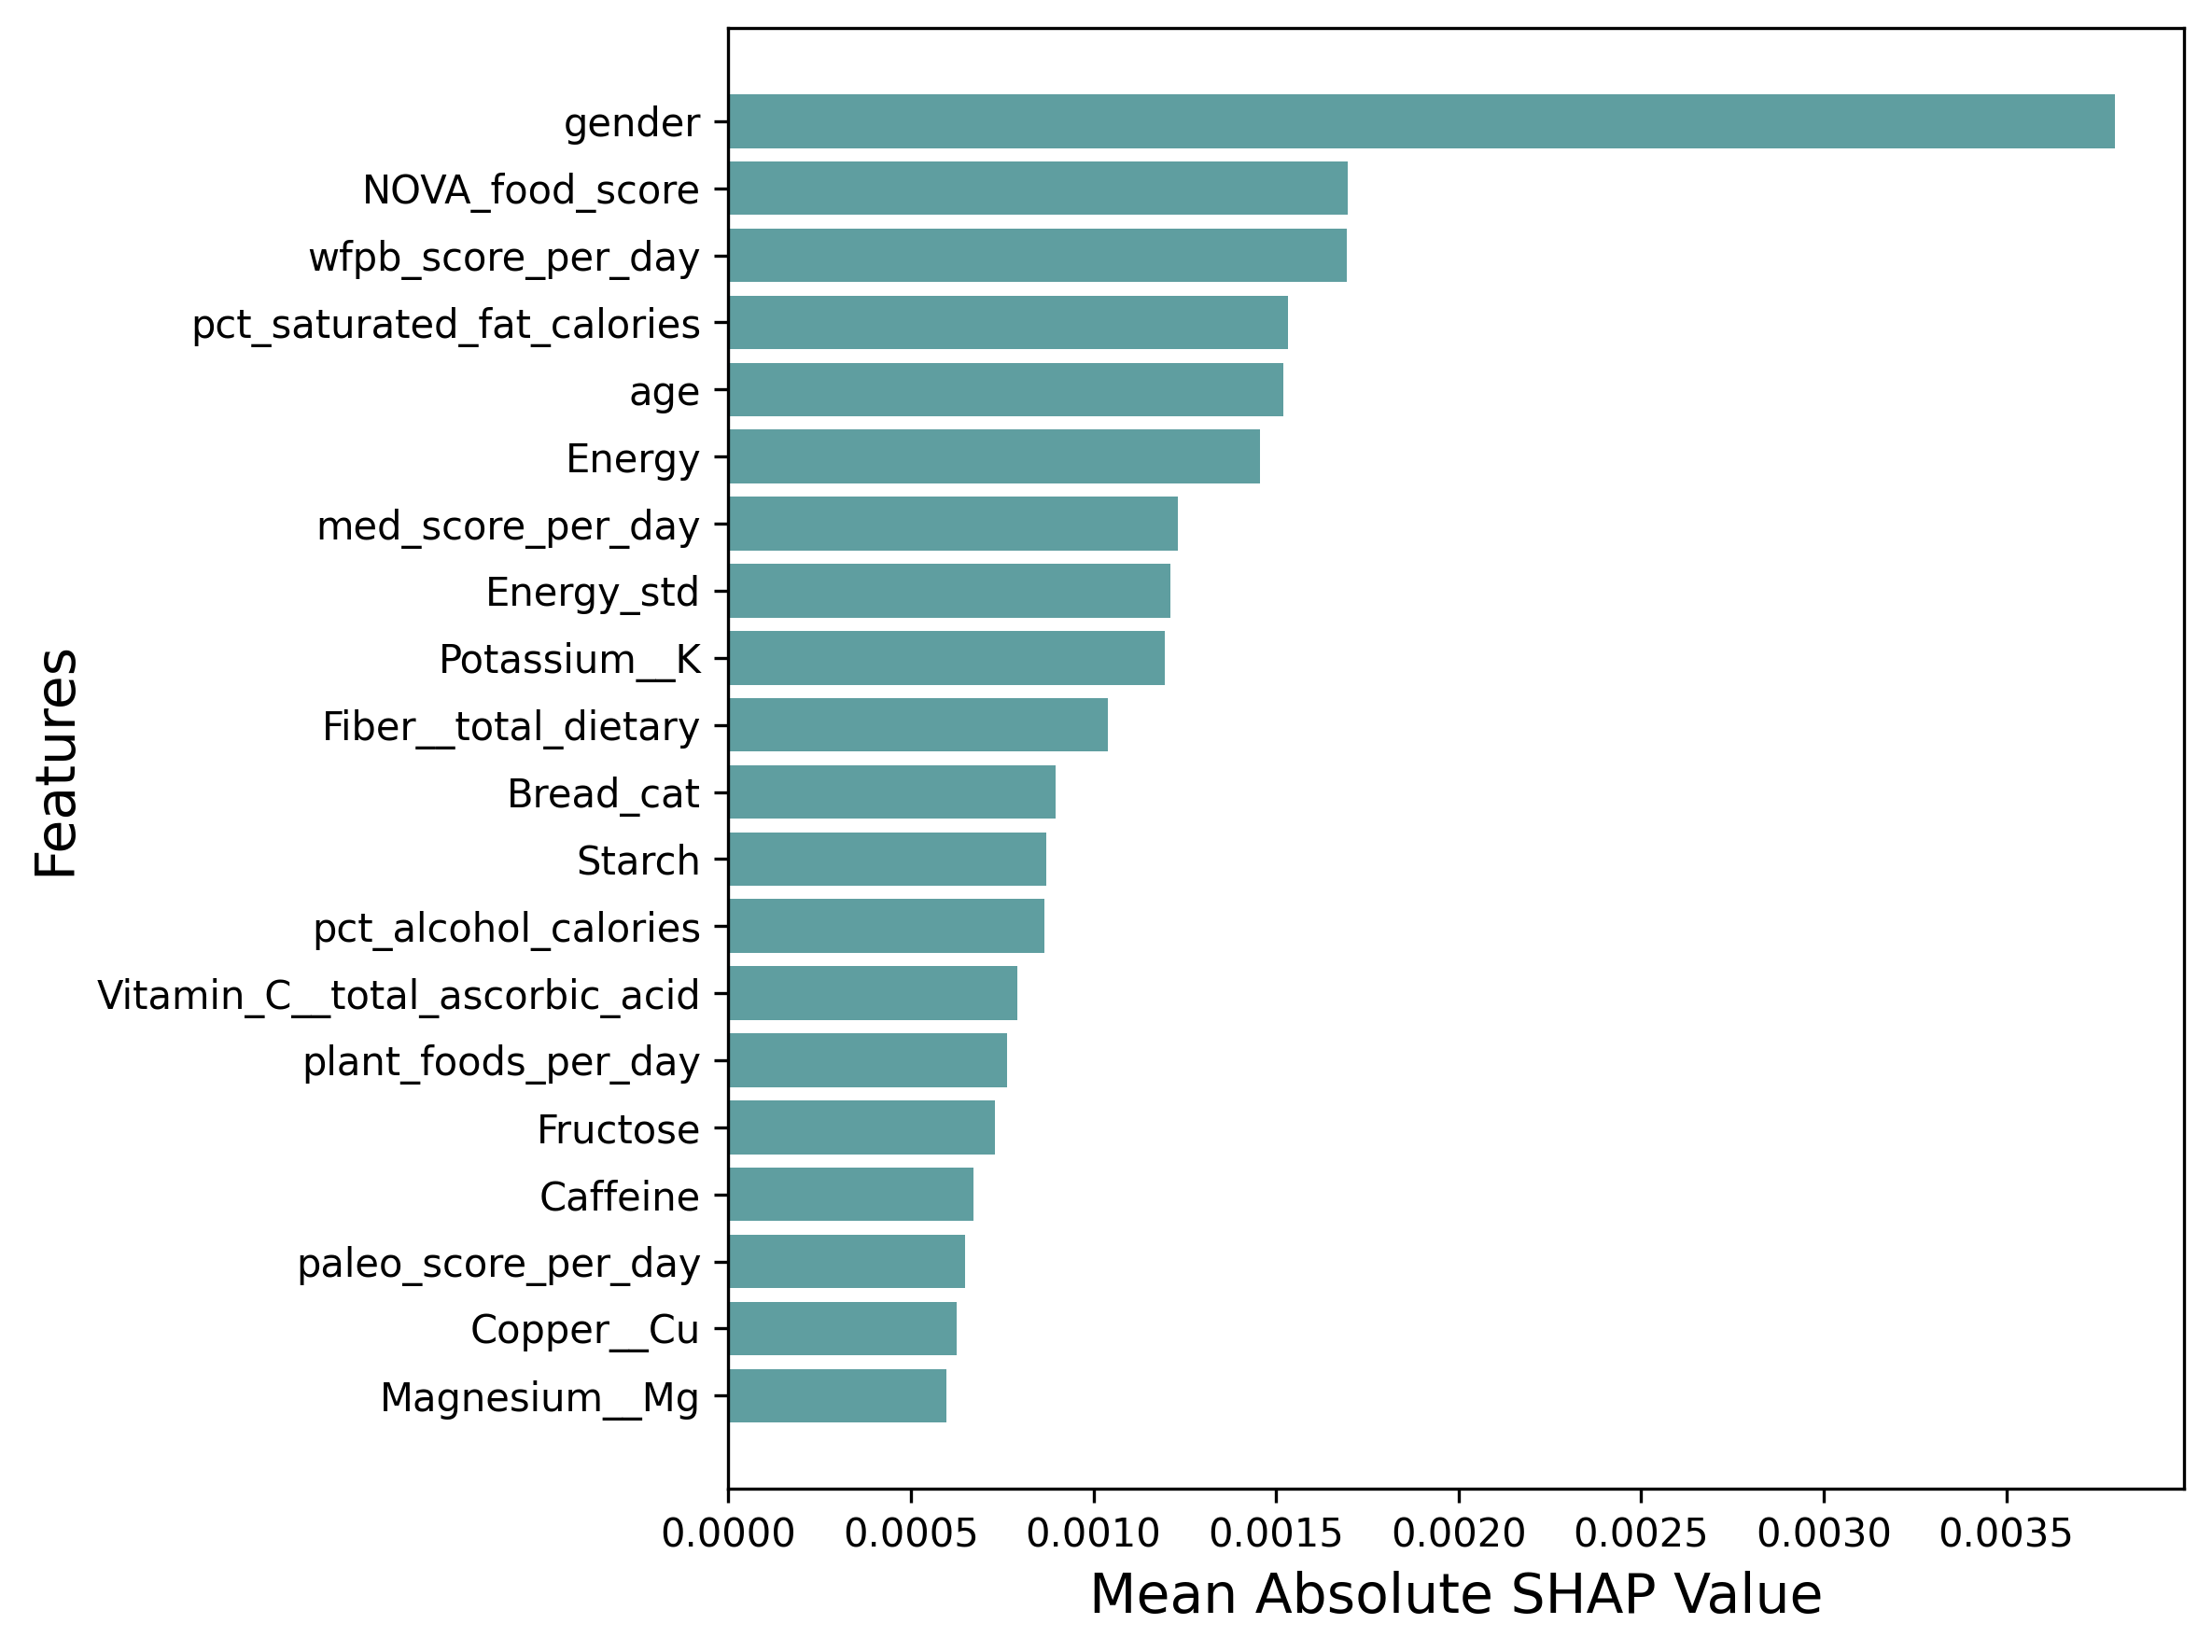

In [52]:
mean_abs_shap_lgbm_abundance_agg_regression = process_mean_abs_shap(
    mean_abs_shap_df = mean_abs_shap_lgbm_abundance_agg_regression, 
    all_features = all_features, 
    top_n = 20
)

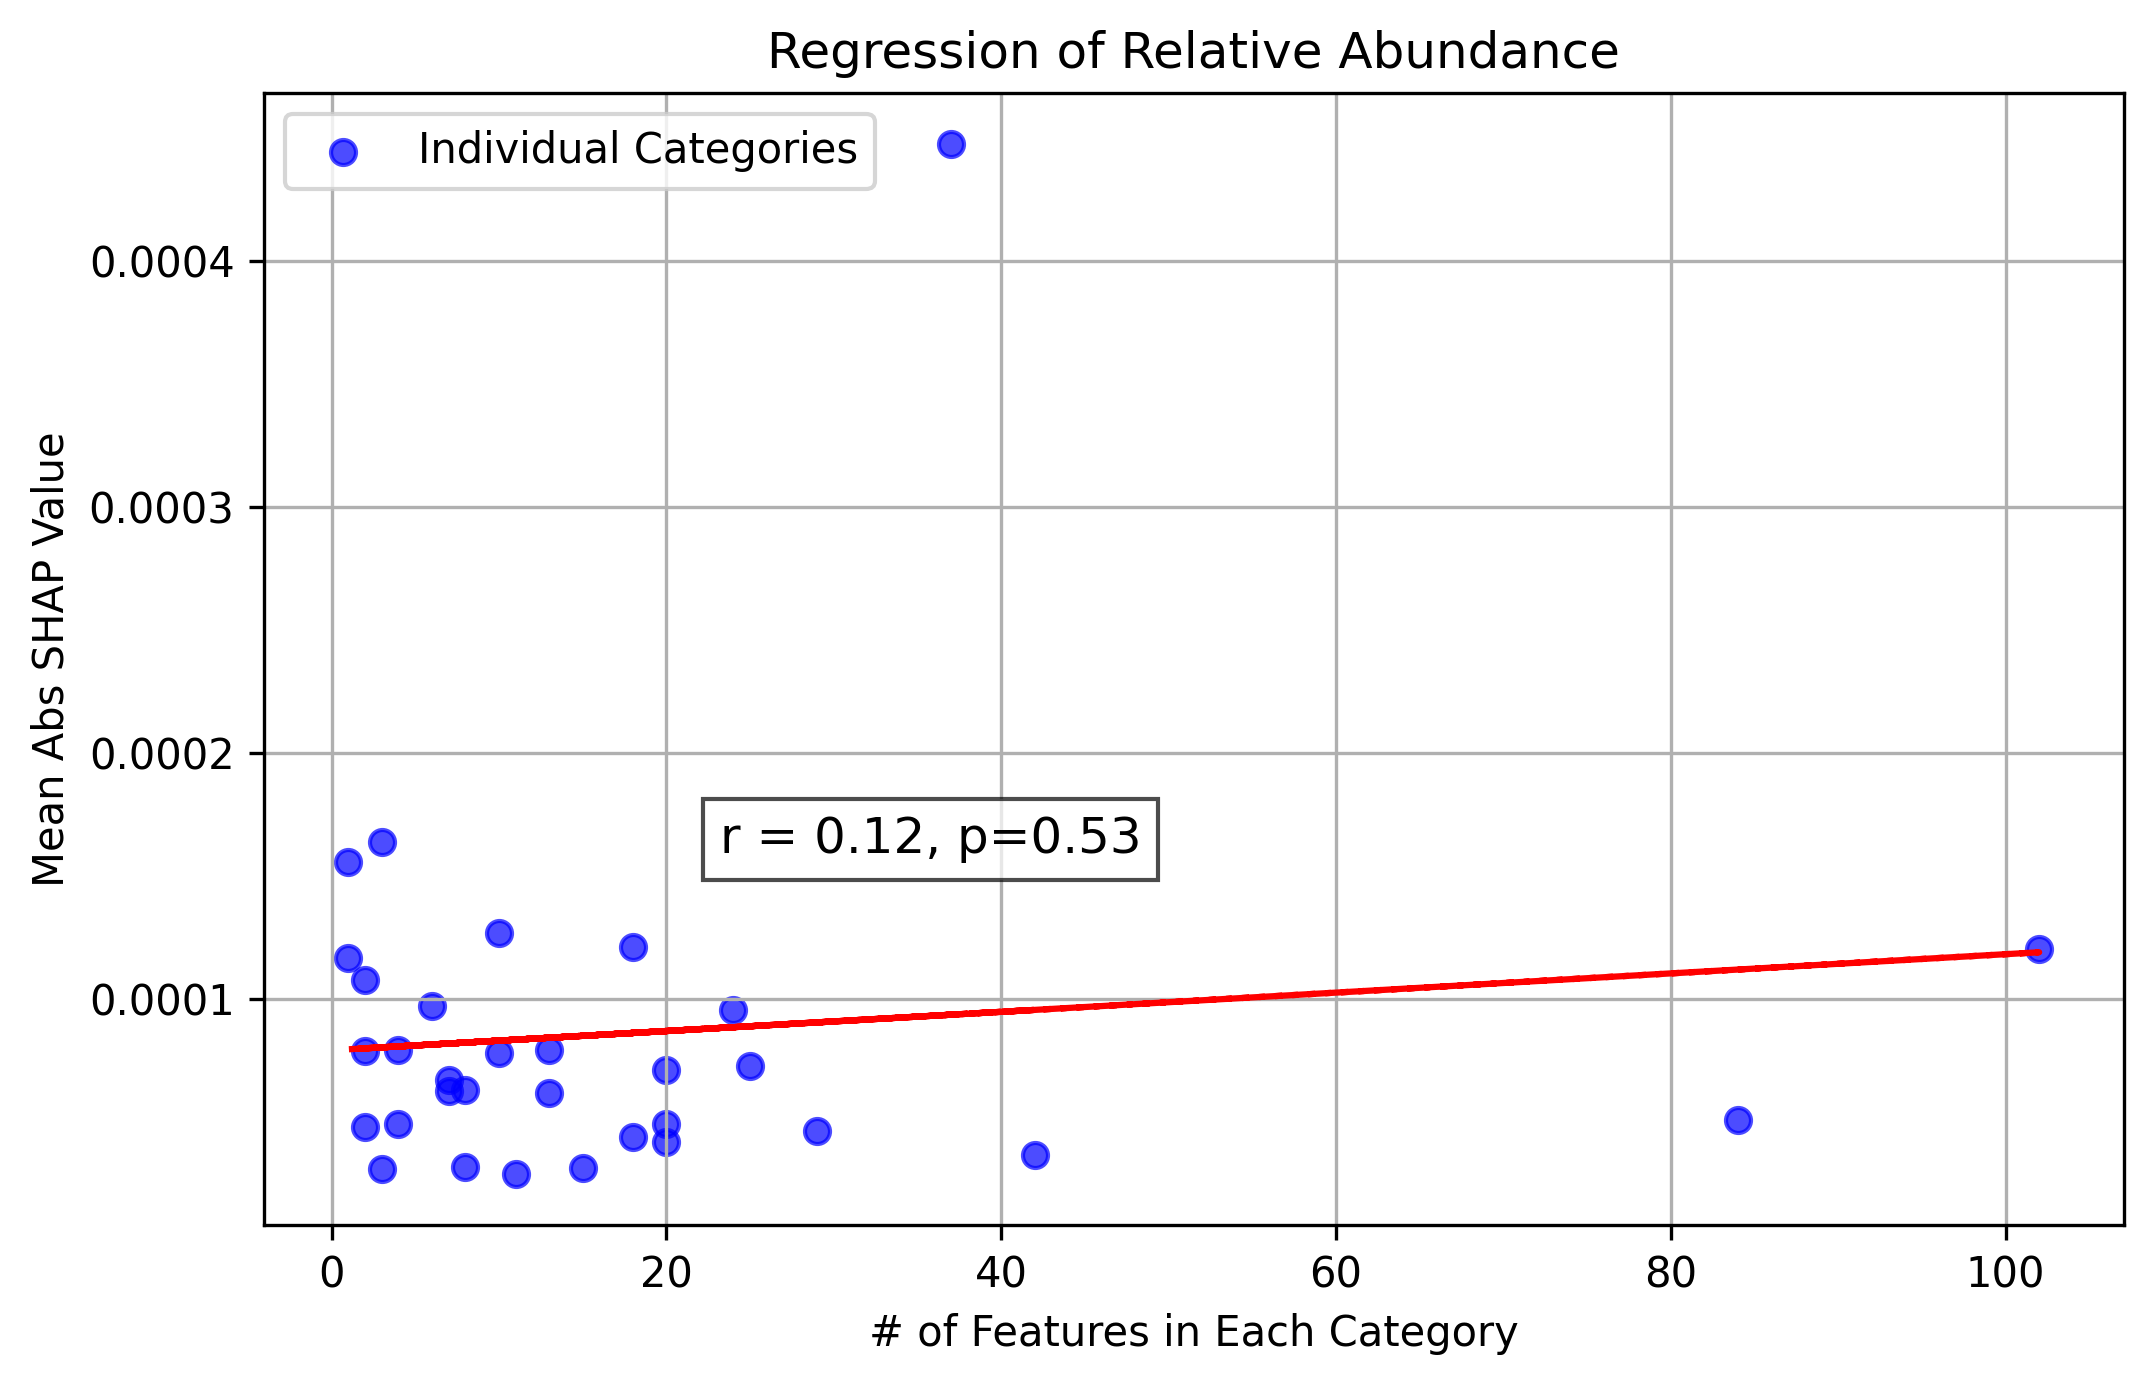

Pearson Correlation Coefficient: 0.1164
P-value: 0.5257


In [32]:
def plot_shap_vs_category_count(mean_abs_shap_df, all_features, category_counts_df, significant_targets_indices, title):
    """
    Plots the relationship between feature count per category and mean absolute SHAP values.

    Parameters:
    - mean_abs_shap_df (DataFrame): DataFrame containing SHAP values.
    - all_features (list or Series): List of all feature names.
    - category_counts_df (DataFrame): DataFrame containing category counts.
    - significant_targets_indices (list): Indices of significant targets to filter.

    Returns:
    - Pearson correlation coefficient (r) and p-value
    """

    if title == 'regression':
        title = "Regression of Relative Abundance"
    elif title == 'given_presence':
        title = "Regression of Relative Abundance Given Species Presence"
    elif title == 'classification':
        title = "Classification of Species Presence / Absence"

    # Step 1: Data Cleaning
    mean_abs_shap_df = mean_abs_shap_df.dropna(axis=1)  # Drop NaN columns
    mean_abs_shap_df = mean_abs_shap_df.iloc[:, significant_targets_indices]  # Filter by significant targets

    # Step 2: Compute Mean Absolute SHAP Values Across Features
    mean_abs_shap_df['mean_abs_shap'] = mean_abs_shap_df.mean(axis=1)
    mean_abs_shap_df = mean_abs_shap_df.loc[0:31, ['mean_abs_shap']]  # Select first 32 features

    # Step 3: Merge Feature Categories with Counts
    mean_abs_shap_df['Category'] = all_features[0:32]
    mean_abs_shap_df = mean_abs_shap_df.merge(category_counts_df, on="Category", how="inner")

    # Step 4: Compute Pearson Correlation
    corr_coefficient, p_value = pearsonr(mean_abs_shap_df["mean_abs_shap"], mean_abs_shap_df["Count"])

    # Step 5: Plot Scatter with Trendline
    plt.figure(figsize=(8, 5), dpi=300)
    plt.scatter(mean_abs_shap_df["Count"], mean_abs_shap_df["mean_abs_shap"],
                 color='blue', alpha=0.7, label="Individual Categories")

    plt.xlabel("# of Features in Each Category")
    plt.ylabel("Mean Abs SHAP Value")
    plt.title(title)

    # Fit a linear trendline
    m, b = np.polyfit(mean_abs_shap_df["Count"], mean_abs_shap_df["mean_abs_shap"], 1)
    plt.plot(mean_abs_shap_df["Count"], m * mean_abs_shap_df["Count"] + b, color="red", linestyle="dashed")

    # Place r and p-value above the trendline
    x_pos = np.percentile(mean_abs_shap_df["Count"], 80)  # 80th percentile of x-axis
    y_pos = np.percentile(mean_abs_shap_df["mean_abs_shap"], 95)  # 90th percentile of y-axis
    plt.text(x_pos, y_pos, f"r = {corr_coefficient:.2f}, p={p_value:.2f}",
             fontsize=12, color="black", ha="left", bbox=dict(facecolor='white', alpha=0.7))

    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Print correlation coefficient
    print(f"Pearson Correlation Coefficient: {corr_coefficient:.4f}")
    print(f"P-value: {p_value:.4f}")

    return corr_coefficient, p_value

if aggregate_features:
    r, p = plot_shap_vs_category_count(
        mean_abs_shap_lgbm_abundance_agg_regression,  # SHAP DataFrame
        all_features,  # List of all features
        category_counts_df,  # DataFrame with category counts
        significant_targets_indices,  # Indices of significant targets
        title=PROBLEM
    )


Why Hard Cheese is not inside the Milk, Cream, Cheese & Yogurts	 category above ^ ?

In [33]:
# mean_abs_shap_ridge_div

In [34]:
# mean_abs_shap_lgbm_abundance = mean_abs_shap_lgbm_abundance.iloc[:, significant_targets_indices]
# mean_abs_shap_lgbm_abundance

In [35]:
# Some predictions are NA if the training set has prevalence >95%
# mean_abs_shap_lgbm_abundance.dropna(axis=1)

In [36]:
# def mean_shap_over_features(mean_abs_shap):
#     mean_abs_shap_lgbm_abundance['mean_abs_shap'] = mean_abs_shap_lgbm_abundance.mean(axis=1)

In [37]:
# mean_abs_shap_lgbm_abundance['mean_abs_shap'] = mean_abs_shap_lgbm_abundance.mean(axis=1)
# mean_abs_shap_lgbm_abundance['mean_abs_shap']

In [38]:
# # mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False)[mean_abs_shap_lgbm_abundance['mean_abs_shap'] > 0.001]
# mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False).head(20)

In [39]:
# # top_shap_all_mic = mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False)[mean_abs_shap_lgbm_abundance['mean_abs_shap'] > 0.001].index
# top_shap_all_mic = mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False).head(20).index
# top_shap_all_mic

In [40]:
# top_fnames_shap_all_mic = pd.Series(all_features).loc[top_shap_all_mic]
# # print(pd.concat([top_fnames_shap_all_mic, mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False)[mean_abs_shap_lgbm_abundance['mean_abs_shap'] > 0.001]], axis=1))
# print(pd.concat([top_fnames_shap_all_mic, mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False).head(20)], axis=1))

In [41]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming the data is provided as described
# # Combining the feature names with their SHAP values
# shap_data = pd.concat([top_fnames_shap_all_mic, mean_abs_shap_lgbm_abundance['mean_abs_shap'].sort_values(ascending=False).head(20)], axis=1)

# # Rename columns for clarity
# shap_data.columns = ['Feature', 'Mean Absolute SHAP Value']

# # Sort values by SHAP for better visual clarity
# shap_data = shap_data.sort_values(by='Mean Absolute SHAP Value', ascending=True)

# # Create a horizontal bar chart
# plt.figure(figsize=(8, 6))
# plt.barh(shap_data['Feature'], shap_data['Mean Absolute SHAP Value'], color='cadetblue', edgecolor='none')

# # Add labels and title
# plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
# plt.ylabel('Features', fontsize=14)
# # plt.title('Top Features by Mean Absolute SHAP Value', fontsize=14)

# # Improve layout
# plt.tight_layout()
# # plt.savefig(home_path + f"figures/{PROBLEM}/mean_abs_shap.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')

# # Show the plot
# plt.show()


In [42]:
# mean_abs_shap_ridge_mic['mean_abs_shap'] = mean_abs_shap_ridge_mic.mean(axis=1)
# mean_abs_shap_ridge_mic['mean_abs_shap']

In [43]:
# mean_abs_shap_ridge_mic['mean_abs_shap'].sort_values(ascending=False)[0:23]

In [44]:
# top_shap_all_mic = mean_abs_shap_ridge_mic['mean_abs_shap'].sort_values(ascending=False)[0:23].index
# top_shap_all_mic

In [45]:
# top_fnames_shap_all_mic = pd.Series(all_features).loc[top_shap_all_mic]
# top_fnames_shap_all_mic

#### Are there foods that especially impact certain microbes?

In [46]:
mean_abs_shap_lgbm_abundance['max'] = mean_abs_shap_lgbm_abundance.max(axis=1)
mean_abs_shap_lgbm_abundance['max_microbe'] = mean_abs_shap_lgbm_abundance.idxmax(axis=1)
mean_abs_shap_lgbm_abundance

,0,1,3,4,5,6,7,9,10,11,...,715,716,717,718,719,721,722,723,max,max_microbe
0,0.000005,0.000002,0.000020,1.111811e-05,0.000013,0.000062,0.000000,0.000007,0.001244,0.000036,...,0.000000,0.000005,0.000000,0.000073,0.000000,0.000003,0.000009,0.000012,0.001244,10
1,0.000003,0.000007,0.000000,8.405643e-07,0.000007,0.000011,0.000018,0.000097,0.000000,0.000000,...,0.000004,0.000016,0.000038,0.000000,0.000023,0.000000,0.000000,0.000005,0.000630,630
2,0.000065,0.000000,0.000023,9.938005e-05,0.000092,0.000000,0.000023,0.000045,0.000121,0.000013,...,0.000003,0.000506,0.000096,0.000087,0.000105,0.000008,0.000122,0.000037,0.001034,634
3,0.000022,0.000000,0.000000,0.000000e+00,0.000020,0.000000,0.000000,0.000033,0.000004,0.000022,...,0.000000,0.000000,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000,0.000578,325
4,0.000031,0.000000,0.000010,1.007767e-06,0.000048,0.000012,0.000007,0.000039,0.000661,0.000004,...,0.000001,0.000007,0.000114,0.000009,0.000003,0.000000,0.000000,0.000000,0.001174,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.000323,0.000056,0.016894,2.831540e-04,0.000631,0.001036,0.020895,0.040032,0.006758,0.000008,...,0.000027,0.000678,0.030160,0.000027,0.000110,0.000004,0.000803,0.002483,0.053344,381
783,0.000007,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000008,0.000016,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000891,237
784,0.000000,0.000000,0.000039,0.000000e+00,0.000000,0.000000,0.000031,0.000006,0.000015,0.000126,...,0.000000,0.001944,0.000588,0.000060,0.000007,0.000014,0.000000,0.000115,0.011999,657
785,0.000105,0.000127,0.000883,9.911564e-05,0.000142,0.000252,0.000719,0.005414,0.000137,0.000063,...,0.000100,0.002023,0.000404,0.002989,0.000103,0.000123,0.000444,0.000189,0.021293,93


In [47]:
max_microbes = mean_abs_shap_lgbm_abundance[mean_abs_shap_lgbm_abundance['max'] > 0.02]
features_of_max_microbes = max_microbes.index
max_microbes

,0,1,3,4,5,6,7,9,10,11,...,715,716,717,718,719,721,722,723,max,max_microbe
146,0.000663,0.000536,0.000135,0.000141,0.000513,0.000546,0.000609,0.000257,0.000856,0.001655,...,0.001009,0.008890,0.004838,0.000501,0.000571,0.001894,0.000234,0.000284,0.020112,595
360,0.000089,0.000112,0.000365,0.000284,0.000102,0.000411,0.000383,0.000910,0.000574,0.000048,...,0.000067,0.000489,0.001281,0.000801,0.000340,0.000238,0.000038,0.000230,0.024393,34
379,0.000172,0.000094,0.000443,0.000844,0.000042,0.000989,0.000260,0.000074,0.000057,0.000117,...,0.000035,0.000092,0.000077,0.000059,0.000442,0.000124,0.000050,0.000125,0.043908,46
636,0.000379,0.000124,0.006915,0.001382,0.001399,0.001941,0.004428,0.008712,0.000676,0.001909,...,0.000076,0.001610,0.009273,0.000332,0.001245,0.000372,0.000346,0.003610,0.031008,381
643,0.000330,0.000133,0.000148,0.000055,0.000074,0.000363,0.000303,0.000826,0.000079,0.000155,...,0.000554,0.002950,0.000206,0.000155,0.000237,0.000190,0.000136,0.000115,0.030633,458
688,0.000091,0.000552,0.000274,0.000105,0.000114,0.000275,0.000530,0.000677,0.000107,0.000853,...,0.000388,0.005273,0.001573,0.000546,0.000287,0.000824,0.000086,0.000372,0.030018,595
699,0.000191,0.000197,0.000302,0.000119,0.000137,0.000223,0.000452,0.001946,0.000104,0.000109,...,0.000150,0.000174,0.000426,0.000194,0.000167,0.000102,0.000120,0.000518,0.023834,237
713,0.000074,0.000174,0.000503,0.000041,0.000090,0.000213,0.000955,0.000304,0.000317,0.000076,...,0.000092,0.000692,0.000584,0.002374,0.000066,0.000298,0.000080,0.000321,0.026196,32
720,0.000100,0.000374,0.000331,0.000216,0.000185,0.000387,0.000654,0.000563,0.000439,0.000135,...,0.000155,0.000516,0.000555,0.000284,0.000044,0.000127,0.000071,0.000126,0.030136,32
729,0.000311,0.000123,0.006445,0.002167,0.001328,0.007410,0.001833,0.008908,0.000476,0.000459,...,0.000115,0.000714,0.003546,0.000207,0.000286,0.000090,0.000311,0.003758,0.024135,381


In [48]:
fnames_of_max_microbes = pd.Series(all_features).loc[features_of_max_microbes]
fnames_of_max_microbes

KeyError: '[360, 379, 636, 643, 688, 699, 713, 720, 729, 744, 764, 778, 781, 782, 785] not in index'

In [ ]:
specific_mic_dict = {}
for f_index in features_of_max_microbes:
    mic_index = max_microbes.loc[f_index, "max_microbe"]
    print(mic_index)
    specific_mic_dict[fnames_of_max_microbes[f_index]] = map_df.loc[int(mic_index)]["Microbe_Name"]
    print(map_df.loc[int(mic_index)]["Microbe_Name"])
specific_mic_dict


595


NameError: name 'fnames_of_max_microbes' is not defined

#### Three diet features impact none

In [ ]:
bottom_fnames_shap_all_mic = pd.Series(all_features).loc[[735, 729, 721]]
bottom_fnames_shap_all_mic

735         med_score_per_day_std
729    pct_saturated_fat_calories
721              pct_fat_calories
dtype: object

#### Predominant diet feature across microbes

In [ ]:
# transpose so rows are microbes and cols are features?
# for each microbe, rank the features abs shap from 1 (highest) to 745 (lowest).
# For each feature, sum its rank across the microbes.
# Return the features with the lowest sum of rank.

In [ ]:
mean_abs_shap_lgbm_abundance

,0,1,3,4,5,6,7,9,10,11,...,717,718,719,721,722,723,724,mean_abs_shap,max,max_microbe
0,0.000005,0.000002,0.000020,1.111811e-05,0.000013,0.000062,0.000000,0.000007,0.001244,0.000036,...,0.000000,0.000073,0.000000,0.000003,0.000009,0.000012,0.000003,0.000034,0.001244,10
1,0.000003,0.000007,0.000000,8.405643e-07,0.000007,0.000011,0.000018,0.000097,0.000000,0.000000,...,0.000038,0.000000,0.000023,0.000000,0.000000,0.000005,0.000003,0.000023,0.000630,630
2,0.000065,0.000000,0.000023,9.938005e-05,0.000092,0.000000,0.000023,0.000045,0.000121,0.000013,...,0.000096,0.000087,0.000105,0.000008,0.000122,0.000037,0.000195,0.000068,0.001034,634
3,0.000022,0.000000,0.000000,0.000000e+00,0.000020,0.000000,0.000000,0.000033,0.000004,0.000022,...,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000,0.000020,0.000015,0.000578,325
4,0.000031,0.000000,0.000010,1.007767e-06,0.000048,0.000012,0.000007,0.000039,0.000661,0.000004,...,0.000114,0.000009,0.000003,0.000000,0.000000,0.000000,0.000000,0.000049,0.001174,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.000323,0.000056,0.016894,2.831540e-04,0.000631,0.001036,0.020895,0.040032,0.006758,0.000008,...,0.030160,0.000027,0.000110,0.000004,0.000803,0.002483,0.000024,0.004029,0.053344,381
783,0.000007,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000008,0.000016,0.000000,0.000002,...,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000891,237
784,0.000000,0.000000,0.000039,0.000000e+00,0.000000,0.000000,0.000031,0.000006,0.000015,0.000126,...,0.000588,0.000060,0.000007,0.000014,0.000000,0.000115,0.000000,0.000075,0.011999,657
785,0.000105,0.000127,0.000883,9.911564e-05,0.000142,0.000252,0.000719,0.005414,0.000137,0.000063,...,0.000404,0.002989,0.000103,0.000123,0.000444,0.000189,0.002081,0.001792,0.021293,93


In [ ]:
mean_abs_shap_lgbm_abundance.drop(["max", "max_microbe", "mean_abs_shap"], axis=1, inplace=True)
mean_abs_shap_lgbm_abundance

,0,1,3,4,5,6,7,9,10,11,...,714,715,716,717,718,719,721,722,723,724
0,0.000005,0.000002,0.000020,1.111811e-05,0.000013,0.000062,0.000000,0.000007,0.001244,0.000036,...,0.000007,0.000000,0.000005,0.000000,0.000073,0.000000,0.000003,0.000009,0.000012,0.000003
1,0.000003,0.000007,0.000000,8.405643e-07,0.000007,0.000011,0.000018,0.000097,0.000000,0.000000,...,0.000007,0.000004,0.000016,0.000038,0.000000,0.000023,0.000000,0.000000,0.000005,0.000003
2,0.000065,0.000000,0.000023,9.938005e-05,0.000092,0.000000,0.000023,0.000045,0.000121,0.000013,...,0.000533,0.000003,0.000506,0.000096,0.000087,0.000105,0.000008,0.000122,0.000037,0.000195
3,0.000022,0.000000,0.000000,0.000000e+00,0.000020,0.000000,0.000000,0.000033,0.000004,0.000022,...,0.000000,0.000000,0.000000,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000,0.000020
4,0.000031,0.000000,0.000010,1.007767e-06,0.000048,0.000012,0.000007,0.000039,0.000661,0.000004,...,0.000208,0.000001,0.000007,0.000114,0.000009,0.000003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.000323,0.000056,0.016894,2.831540e-04,0.000631,0.001036,0.020895,0.040032,0.006758,0.000008,...,0.041127,0.000027,0.000678,0.030160,0.000027,0.000110,0.000004,0.000803,0.002483,0.000024
783,0.000007,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000008,0.000016,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000
784,0.000000,0.000000,0.000039,0.000000e+00,0.000000,0.000000,0.000031,0.000006,0.000015,0.000126,...,0.000013,0.000000,0.001944,0.000588,0.000060,0.000007,0.000014,0.000000,0.000115,0.000000
785,0.000105,0.000127,0.000883,9.911564e-05,0.000142,0.000252,0.000719,0.005414,0.000137,0.000063,...,0.000407,0.000100,0.002023,0.000404,0.002989,0.000103,0.000123,0.000444,0.000189,0.002081


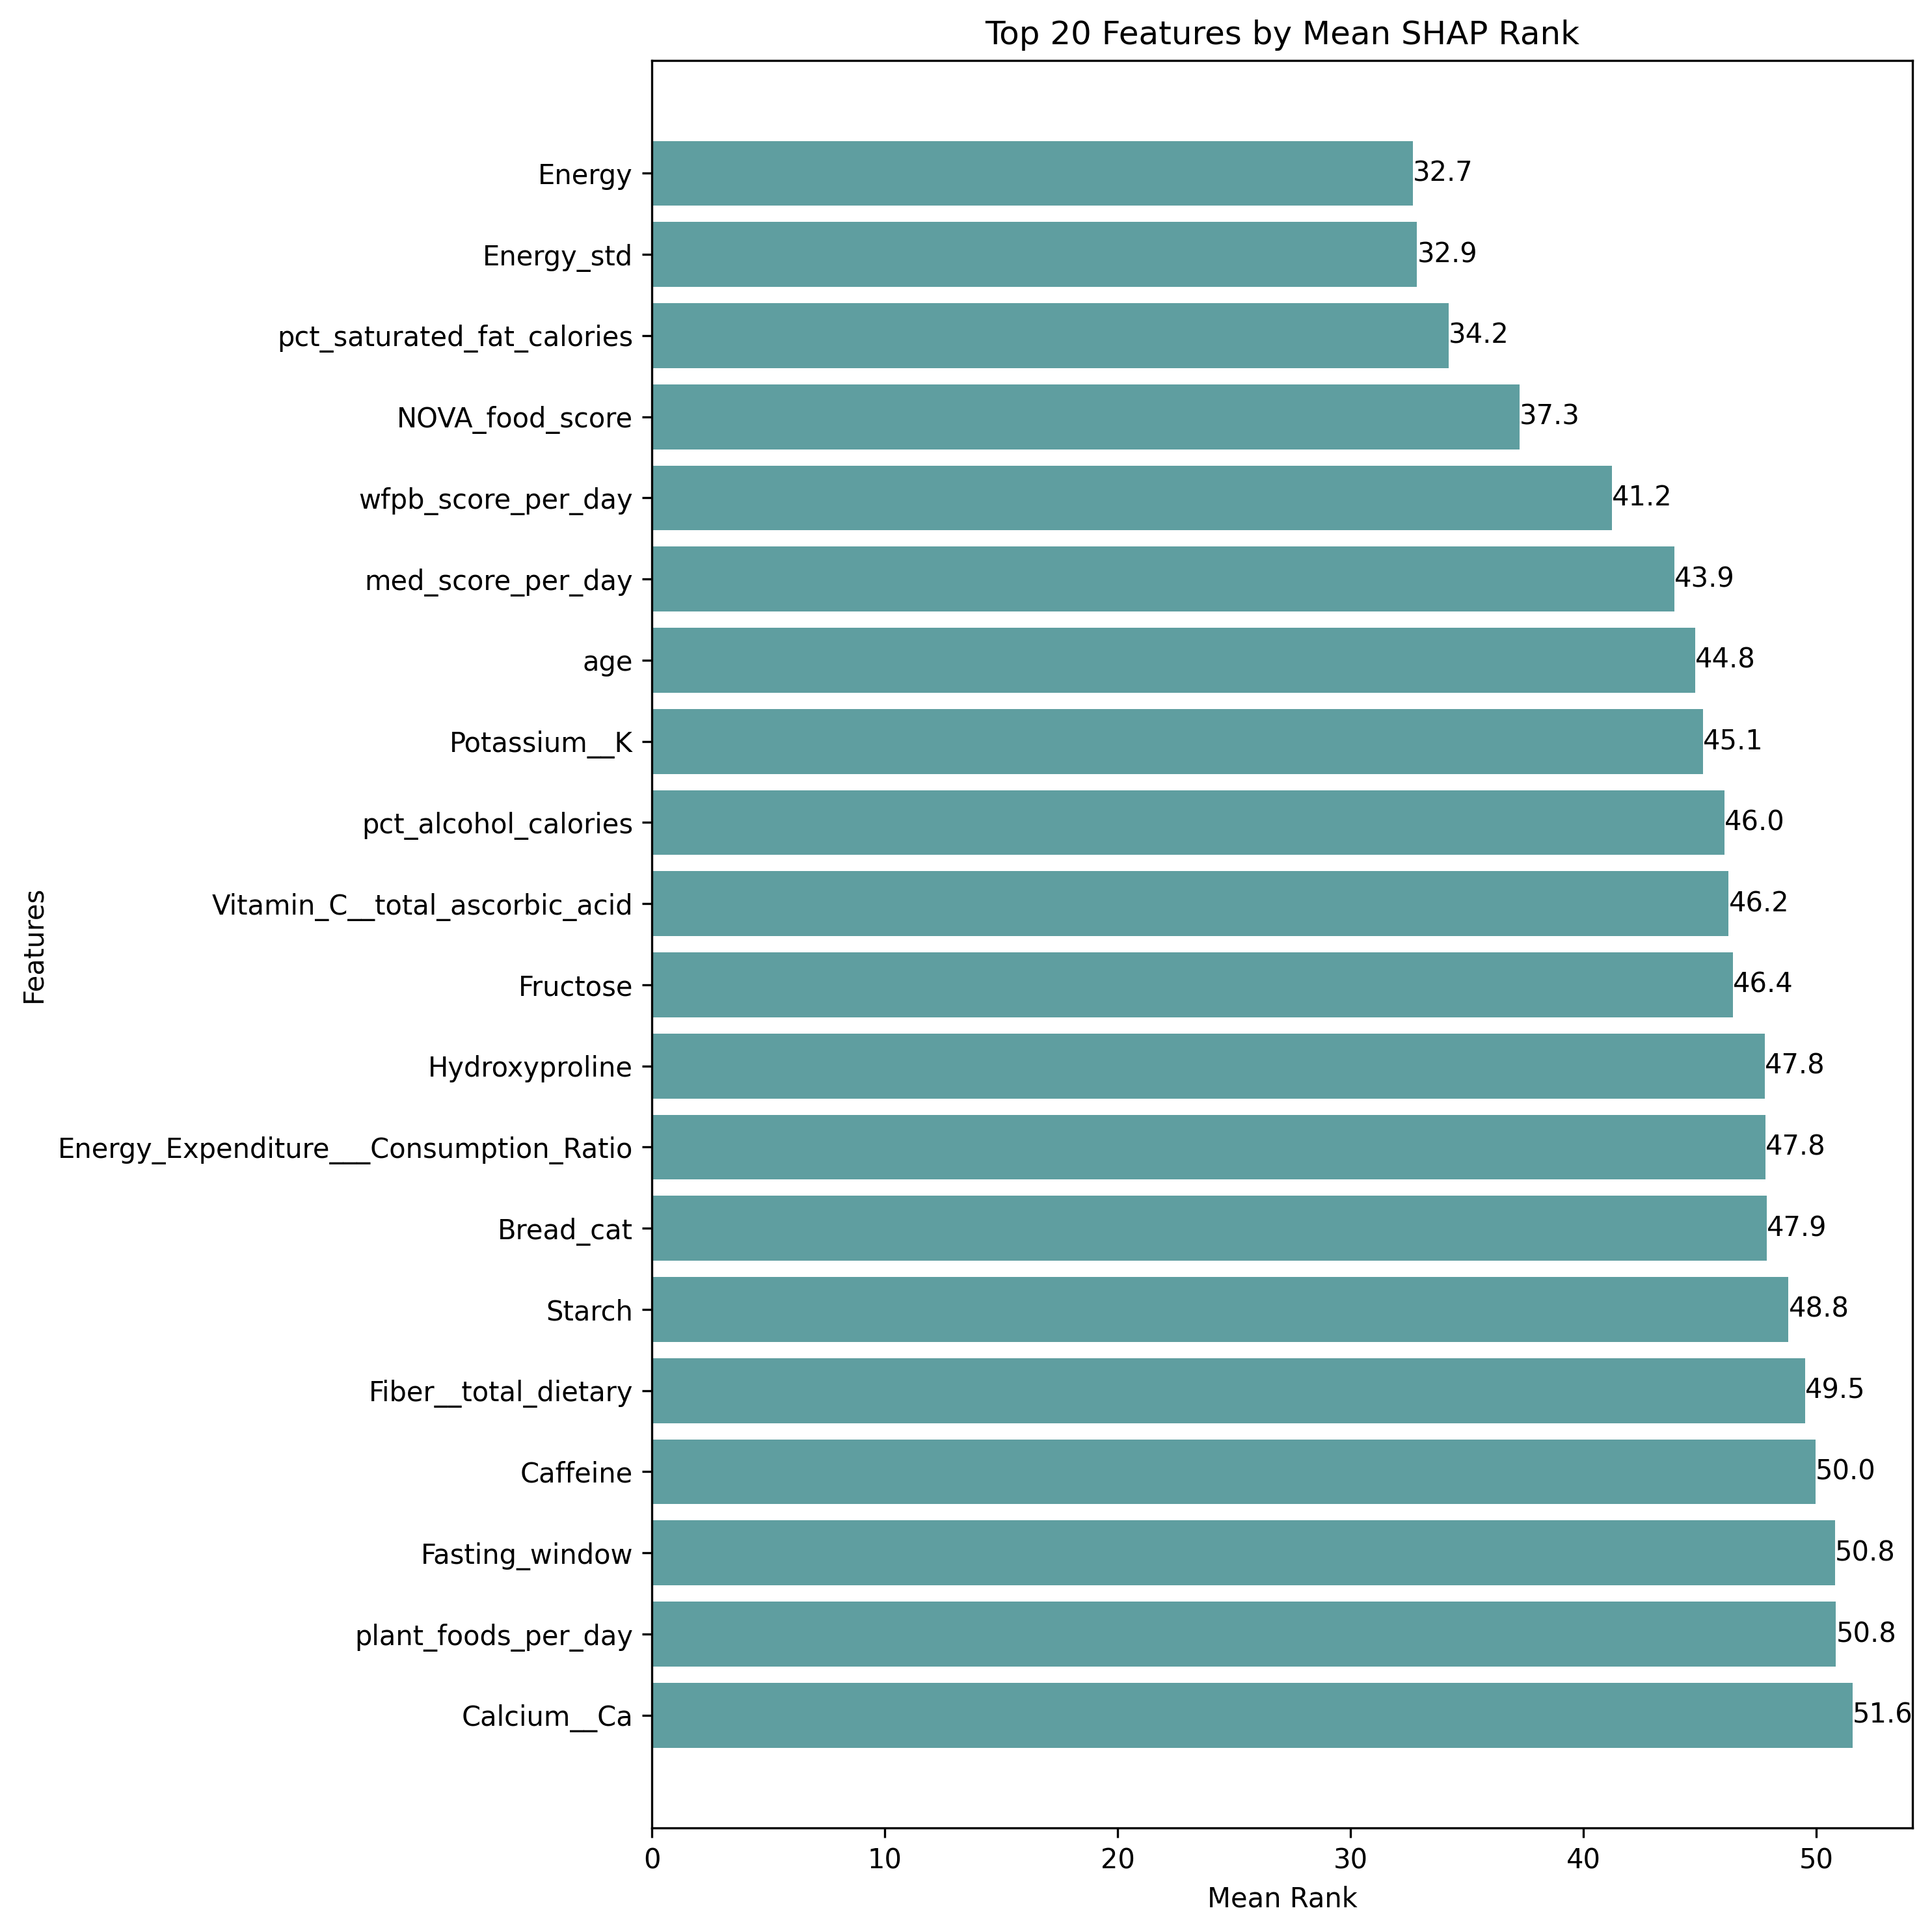

In [56]:
def analyze_shap_ranks(df, all_features, top_n=20):
    """
    Analyze mean absolute SHAP values and create rank visualization.
    
    Parameters:
    df (pd.DataFrame): DataFrame with features as rows and targets as columns
    all_features (pd.Series): Series containing feature names
    top_n (int): Number of top features to display
    
    Returns:
    tuple: (mean_ranks DataFrame, figure)
    """
    # Calculate ranks for each target (column)
    # Higher SHAP values should have lower ranks (rank 1 is highest)
    ranks = df.rank(ascending=False)

    # Calculate mean rank across all targets for each feature
    mean_ranks = ranks.mean(axis=1)
    
    # Get top N features by mean rank
    top_features = mean_ranks.sort_values().head(top_n)
    
    # Get actual feature names
    feature_names = pd.Series(all_features).loc[top_features.index]
    
    # Sort features by rank (highest to lowest)
    sorted_indices = np.argsort(top_features.values)[::-1]
    sorted_features = feature_names.iloc[sorted_indices]
    sorted_values = top_features.values[sorted_indices]
    
    # Create visualization
    plt.figure(figsize=(10, 10), dpi=300)
    
    # Create horizontal bar plot with sorted values
    bars = plt.barh(
        y=np.arange(len(sorted_features)),
        width=sorted_values,
        color='cadetblue',
        edgecolor=None
    )
    
    # Customize the plot
    plt.ylabel('Features')
    plt.xlabel('Mean Rank')
    plt.title(f'Top {top_n} Features by Mean SHAP Rank')
    
    # Add feature names as y-tick labels
    plt.yticks(np.arange(len(sorted_features)), sorted_features)
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}',
                ha='left', va='center')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Create summary DataFrame with actual feature names
    summary_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Rank': top_features.values,
        'Std_Rank': ranks.loc[top_features.index].std(axis=1),
        'Min_Rank': ranks.loc[top_features.index].min(axis=1),
        'Max_Rank': ranks.loc[top_features.index].max(axis=1)
    })
    
    # Sort summary DataFrame to match plot order
    summary_df = summary_df.iloc[sorted_indices]

    # Save the figure
    plt.savefig(home + f"figures/{PROBLEM}/mean_shap_ranks{aggregation}.png", 
                dpi=300, facecolor="white", transparent=False, bbox_inches='tight')

    # Show the plot
    plt.show()
    
    return summary_df

summary_df = analyze_shap_ranks(mean_abs_shap_lgbm_abundance_agg_regression, all_features, top_n=20)

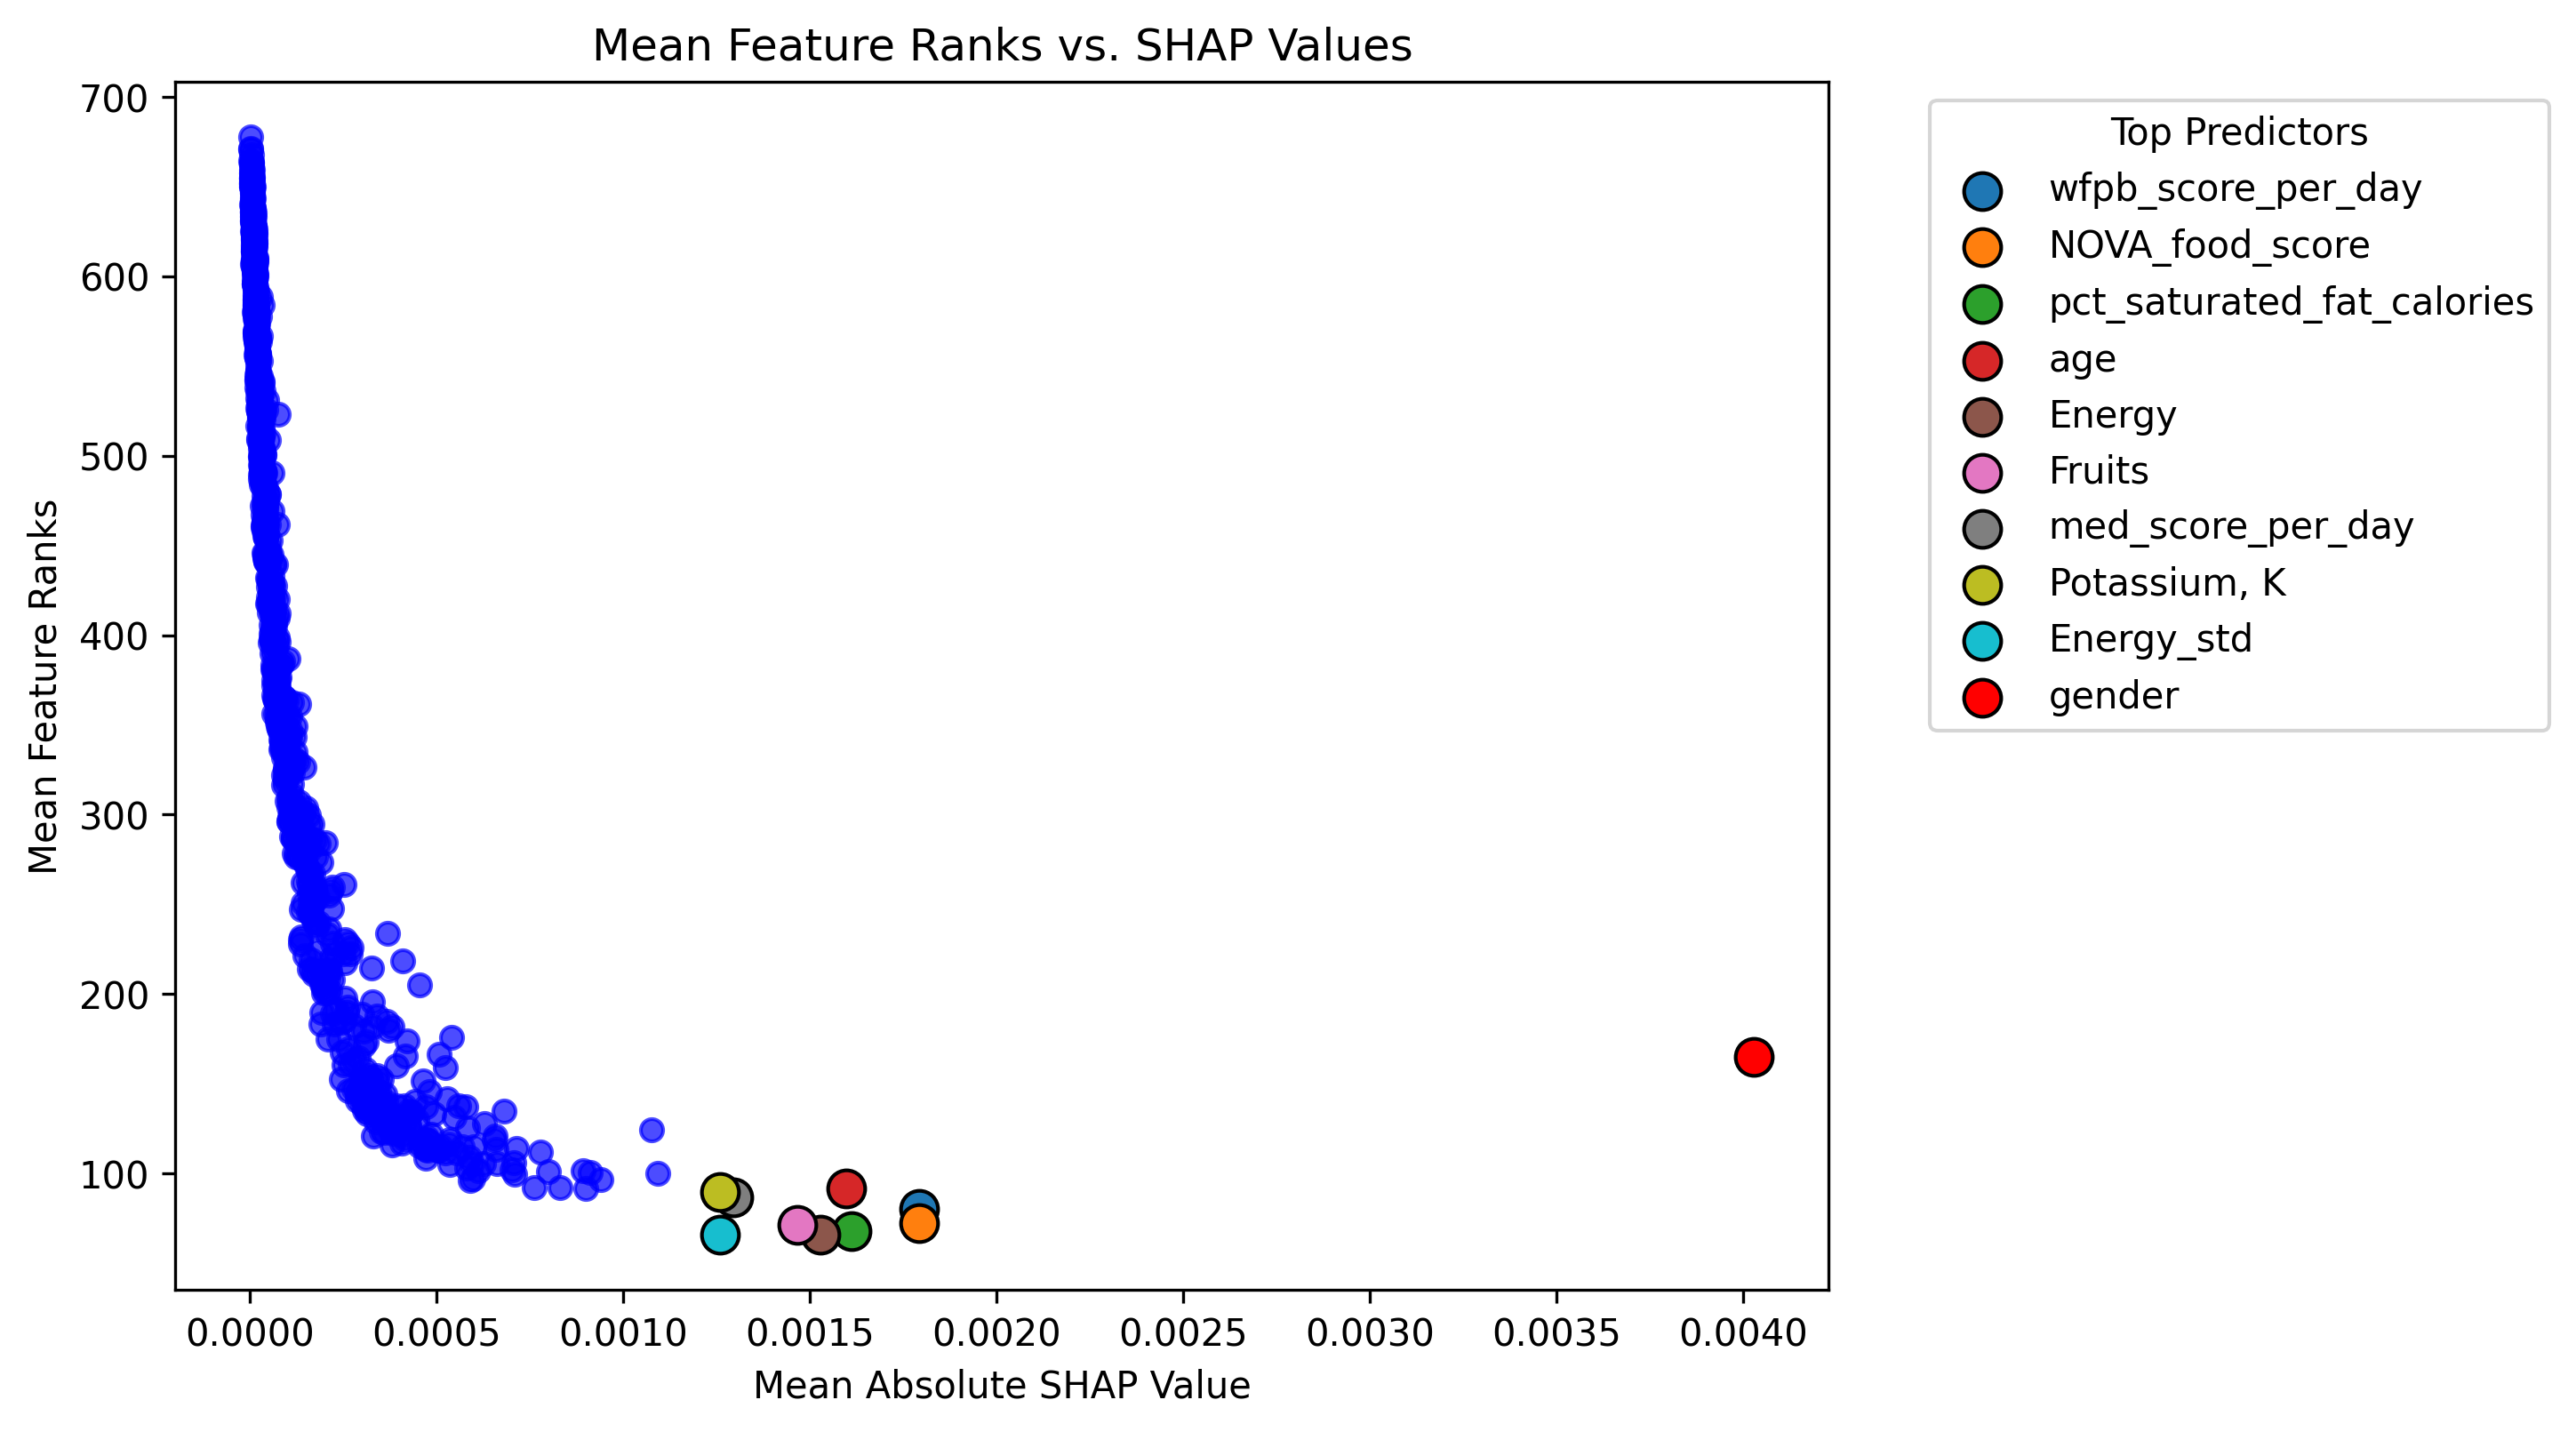

In [ ]:
def highlight_features_with_gender(summary_df, shap_threshold=0.0010, rank_threshold=100):
    """
    Scatter plot with:
        - 'gender' feature always colored red.
        - Other high SHAP & low Rank features having a different color from 'tab10'.
        - Labels in the legend instead of above the points.
    
    Parameters:
    summary_df (pd.DataFrame): DataFrame with 'Mean_Abs_SHAP' and 'Mean_Rank' columns.
    shap_threshold (float): SHAP value threshold for highlighting points.
    rank_threshold (int): Rank threshold for highlighting important features.

    Returns:
    None (displays the scatter plot).
    """
    plt.figure(figsize=(8, 6), dpi=300)

    # Identify high SHAP and low Rank features
    high_shap_low_rank = summary_df[ 
        (summary_df["Mean_Abs_SHAP"] > shap_threshold) & 
        (summary_df["Mean_Rank"] < rank_threshold)
    ]
    other_features = summary_df[ 
        ~((summary_df["Mean_Abs_SHAP"] > shap_threshold) & 
          (summary_df["Mean_Rank"] < rank_threshold))
    ]

    # Always include gender, even if it doesn’t meet the thresholds
    gender_row = summary_df[summary_df["Feature"] == "gender"]
    if not gender_row.empty:
        high_shap_low_rank = pd.concat([high_shap_low_rank, gender_row]).drop_duplicates()

    # Plot other features in blue
    plt.scatter(other_features["Mean_Abs_SHAP"], other_features["Mean_Rank"], alpha=0.7, color='blue')

    colors = plt.cm.get_cmap("tab10", len(high_shap_low_rank) - 1)  # Use 'tab10' for the non-gender features

    # Plot and add to legend instead of annotating on the graph
    legend_handles = []
    for i, (_, row) in enumerate(high_shap_low_rank.iterrows()):
        if row["Feature"] == "gender":
            color = 'red'  # Assign red color to 'gender'
        else:
            color = colors(i)  # Assign color from tab10 to other features
        
        scatter = plt.scatter(
            row["Mean_Abs_SHAP"], 
            row["Mean_Rank"], 
            color=color, s=100, edgecolors='black', label=row["Feature"]
        )
        legend_handles.append(scatter)  # Store for legend

    # Labels and formatting
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Mean Feature Ranks")
    plt.title(f"Mean Feature Ranks vs. SHAP Values")

    # Move labels to the legend
    plt.legend(handles=legend_handles, title="Top Predictors", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Run the visualization
highlight_features_with_gender(summary_df, shap_threshold=0.0010, rank_threshold=100)

#### What are the SHAP values for the highly correlated microbes?

Summary plots are done in "SHAP_summary_plot.py"

In [ ]:
# for microbe_index in top_microbes.index:
#     top_coefs = mean_abs_shap_lgbm_abundance.iloc[:,microbe_index].sort_values(ascending=False)[0:20]
#     top_fnames = pd.Series(lgbm_diet_fnames[0]).loc[top_coefs.index]
#     to_plot = pd.DataFrame(top_coefs).set_index(top_fnames)
#     to_plot.columns = ['']
#     print(to_plot)
#     to_plot.plot.barh()
#     plt.title("What dietary features predict the highly correlated microbes?")
#     plt.legend().remove()
#     # plt.xticks(rotation=90)
#     plt.savefig("top_microbes_features_freq.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
#     plt.show()
#     plt.clf()

### Microbes with one extreme feature
The first shap value is at least twice the second shap value.

In [ ]:
mean_abs_shap_lgbm_abundance

,0,1,3,4,5,6,7,9,10,11,...,714,715,716,717,718,719,721,722,723,724
0,0.000005,0.000002,0.000020,1.111811e-05,0.000013,0.000062,0.000000,0.000007,0.001244,0.000036,...,0.000007,0.000000,0.000005,0.000000,0.000073,0.000000,0.000003,0.000009,0.000012,0.000003
1,0.000003,0.000007,0.000000,8.405643e-07,0.000007,0.000011,0.000018,0.000097,0.000000,0.000000,...,0.000007,0.000004,0.000016,0.000038,0.000000,0.000023,0.000000,0.000000,0.000005,0.000003
2,0.000065,0.000000,0.000023,9.938005e-05,0.000092,0.000000,0.000023,0.000045,0.000121,0.000013,...,0.000533,0.000003,0.000506,0.000096,0.000087,0.000105,0.000008,0.000122,0.000037,0.000195
3,0.000022,0.000000,0.000000,0.000000e+00,0.000020,0.000000,0.000000,0.000033,0.000004,0.000022,...,0.000000,0.000000,0.000000,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000,0.000020
4,0.000031,0.000000,0.000010,1.007767e-06,0.000048,0.000012,0.000007,0.000039,0.000661,0.000004,...,0.000208,0.000001,0.000007,0.000114,0.000009,0.000003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.000323,0.000056,0.016894,2.831540e-04,0.000631,0.001036,0.020895,0.040032,0.006758,0.000008,...,0.041127,0.000027,0.000678,0.030160,0.000027,0.000110,0.000004,0.000803,0.002483,0.000024
783,0.000007,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000008,0.000016,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000
784,0.000000,0.000000,0.000039,0.000000e+00,0.000000,0.000000,0.000031,0.000006,0.000015,0.000126,...,0.000013,0.000000,0.001944,0.000588,0.000060,0.000007,0.000014,0.000000,0.000115,0.000000
785,0.000105,0.000127,0.000883,9.911564e-05,0.000142,0.000252,0.000719,0.005414,0.000137,0.000063,...,0.000407,0.000100,0.002023,0.000404,0.002989,0.000103,0.000123,0.000444,0.000189,0.002081


In [ ]:
mean_abs_shap_lgbm_abundance_transposed = mean_abs_shap_lgbm_abundance.transpose()

def first_second_ratio(row):
    sorted_row = row.sort_values(ascending=False)
    return sorted_row.iloc[0] >= 10 * sorted_row.iloc[1]

mic_with_extreme_feature = mean_abs_shap_lgbm_abundance_transposed[mean_abs_shap_lgbm_abundance_transposed.apply(first_second_ratio, axis=1)]
mic_with_extreme_feature


,0,1,2,3,4,5,6,7,8,9,...,777,778,779,780,781,782,783,784,785,786
187,0.0,0.0,0.000008,0.000016,8.123689e-07,0.000123,0.0,0.00001,0.000219,0.000112,...,0.000281,0.000292,0.000082,0.000103,0.00006,0.020516,0.0,0.0,0.001048,0.000679


In [ ]:
print(mic_with_extreme_feature.iloc[:, 99])
print("The extreme mean shap value:", mic_with_extreme_feature.max(axis=1))
print("The extreme feature index:", mic_with_extreme_feature.idxmax(axis=1))
print("The extreme feature:", pd.Series(all_features).loc[mic_with_extreme_feature.idxmax(axis=1)])
print("The microbe:", mb_names.loc[significant_targets[99], 'species_new'])

187    0.00001
Name: 99, dtype: float64
The extreme mean shap value: 187    0.020516
dtype: float64
The extreme feature index: 187    782
dtype: int64
The extreme feature: 782    gender
dtype: object
The microbe: CAG-611 sp000434175


### Probiotics
* Summary plots of the strains
* Mean shap values of bifidobacterium and of lactobacillus.

In [ ]:
print(mb_names['species_new'][mb_names['species_new'].str.contains("Bi")])

fBin__121|gBin__564|sBin__834             Bifidobacterium animalis_B
fBin__121|gBin__566|sBin__836              Bifidobacterium angulatum
fBin__121|gBin__568|sBin__838      Bifidobacterium pseudocatenulatum
fBin__121|gBin__568|sBin__840            Bifidobacterium catenulatum
fBin__121|gBin__568|sBin__841            Bifidobacterium ruminantium
fBin__121|gBin__568|sBin__842           Bifidobacterium adolescentis
fBin__121|gBin__571|sBin__846                Bifidobacterium bifidum
fBin__121|gBin__572|sBin__848                 Bifidobacterium longum
fBin__508|gBin__1896|sBin__2745                Bilophila sp900550745
fBin__508|gBin__1896|sBin__2746                Bilophila wadsworthia
Name: species_new, dtype: object


In [ ]:
# probiotics = ["Lactobacillus acidophilus", "Lactobacillus rhamnosus", "Lactobacillus casei", "Lactobacillus plantarum", "Bifidobacterium longum", "Bifidobacterium bifidum", "Bifidobacterium lactis", "Streptococcus thermophilus", "Saccharomyces boulardii", "Escherichia coli Nissle 1917", "Enterococcus faecium"]
# probiotics_indices = []

print(mb_names["species_new"][mb_names["species_new"].str.contains("oul")])

# for probiotic in probiotics:
#     mb_code = mb_names[mb_names['species_new'] == probiotic].index
#     print(mb_code)
#     print(mb_code[0])
#     probiotics_indices.append(targets.index(mb_code[0]))

# print(probiotics_indices)

Series([], Name: species_new, dtype: object)


In [ ]:
# Bifidobacterium

def analyze_genus(genus, title=None):
    if title is None:
        title = genus

    genus_names = mb_names['species_new'][mb_names['species_new'].str.contains(genus)].index
    if genus_names.empty:
        print("Genus not found.")
        return
    genus_indices = map_df[map_df["targets"].isin(genus_names)].index
    for genus_index in genus_indices:
        print(map_df.loc[int(genus_index)]["Microbe_Name"])

    # Pearson's correlations

    bifido_corr = lgbm_diet_scores.loc[genus_indices]
    # print(bifido_corr)

    genus_indices = [str(x) for x in genus_indices]
    mean_abs_shap_genus = mean_abs_shap_lgbm_abundance.loc[:, list(genus_indices)]

    mean_abs_shap_genus['mean_abs_shap'] = mean_abs_shap_genus.mean(axis=1)

    top_shap_genus = mean_abs_shap_genus['mean_abs_shap'].sort_values(ascending=False).head(10).index
    top_fnames_shap_genus = pd.Series(all_features).loc[top_shap_genus]

    # Assuming the data is provided as described
    # Combining the feature names with their SHAP values
    shap_data = pd.concat([top_fnames_shap_genus, mean_abs_shap_genus['mean_abs_shap'].sort_values(ascending=False).head(10)], axis=1)

    # Rename columns for clarity
    shap_data.columns = ['Feature', 'Mean Absolute SHAP Value']

    # Sort values by SHAP for better visual clarity
    shap_data = shap_data.sort_values(by='Mean Absolute SHAP Value', ascending=True)

    # Create a horizontal bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(shap_data['Feature'], shap_data['Mean Absolute SHAP Value'], color='cadetblue', edgecolor='none')

    # Add labels and title
    plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    # plt.title('Top Features by Mean Absolute SHAP Value', fontsize=14)

    # Improve layout
    plt.tight_layout()
    # plt.savefig(home_path + f"figures/{PROBLEM}/mean_abs_shap_{title}.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')

    # Show the plot
    plt.show()


In [ ]:
def analyze_genus_ranks(genus, title=None):
    if title is None:
        title = genus

    genus_names = mb_names[mb_names['species_new'].str.contains(genus, regex=True)].index
    if genus_names.empty:
        print("Genus not found.")
        return
    
    genus_names = [name for name in genus_names if name in significant_targets]
    genus_indices = map_df[map_df["targets"].isin(genus_names)].index
    print(genus_indices)
    for genus_index in genus_indices:
        print(map_df.loc[int(genus_index)]["Microbe_Name"])

    # Pearson's correlations
    bifido_corr = lgbm_diet_scores.loc[genus_indices]
    # print(bifido_corr)

    genus_indices = [str(x) for x in genus_indices]
    shap_values_genus = mean_abs_shap_lgbm_abundance.loc[:, list(genus_indices)]

    # Calculate ranks for each target (column)
    ranks = shap_values_genus.rank(ascending=False)
    
    # Calculate mean rank across all targets for each feature
    mean_ranks = ranks.mean(axis=1)
    
    # Get top 10 features by mean rank
    top_features = mean_ranks.sort_values().head(10)
    
    # Get actual feature names
    top_fnames_shap_genus = pd.Series(all_features).loc[top_features.index]
    
    # Sort features by rank (highest to lowest)
    sorted_indices = np.argsort(top_features.values)[::-1]
    sorted_features = top_fnames_shap_genus.iloc[sorted_indices]
    sorted_values = top_features.values[sorted_indices]
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        y=np.arange(len(sorted_features)),
        width=sorted_values,
        color='cadetblue',
        edgecolor=None
    )
    
    # Customize the plot
    plt.ylabel('Features')
    plt.xlabel('Mean Rank')
    plt.title(f'Top 10 Features by Mean SHAP Rank for {title}')
    
    # Add feature names as y-tick labels
    plt.yticks(np.arange(len(sorted_features)), sorted_features)
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                 f'{width:.1f}',
                 ha='left', va='center')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the figure
    # plt.savefig(home_path + f"figures/{PROBLEM}/mean_shap_ranks_{title}.pdf", 
    #             dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Feature': sorted_features.values,
        'Mean_Rank': sorted_values,
        'Std_Rank': ranks.loc[top_features.index].std(axis=1).values,
        'Min_Rank': ranks.loc[top_features.index].min(axis=1).values,
        'Max_Rank': ranks.loc[top_features.index].max(axis=1).values
    })
    
    return summary_df


Bifidobacterium longum
Bifidobacterium adolescentis
Bifidobacterium bifidum
Bifidobacterium catenulatum
Bifidobacterium angulatum
Bifidobacterium animalis_B
Bifidobacterium pseudocatenulatum
Bifidobacterium ruminantium


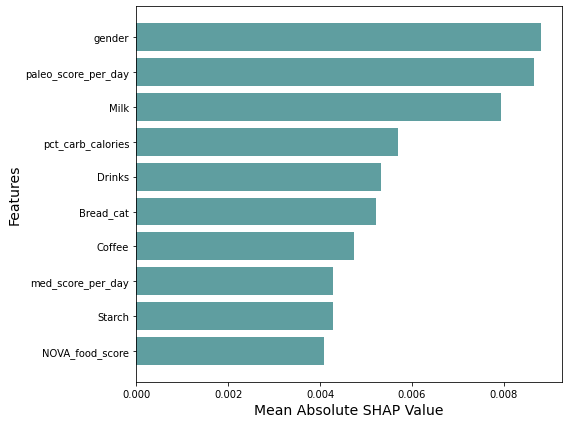

In [ ]:
analyze_genus("Bifidobacterium")


Int64Index([34, 32, 33, 30, 28, 27, 29, 31], dtype='int64')
Bifidobacterium longum
Bifidobacterium adolescentis
Bifidobacterium bifidum
Bifidobacterium catenulatum
Bifidobacterium angulatum
Bifidobacterium animalis_B
Bifidobacterium pseudocatenulatum
Bifidobacterium ruminantium


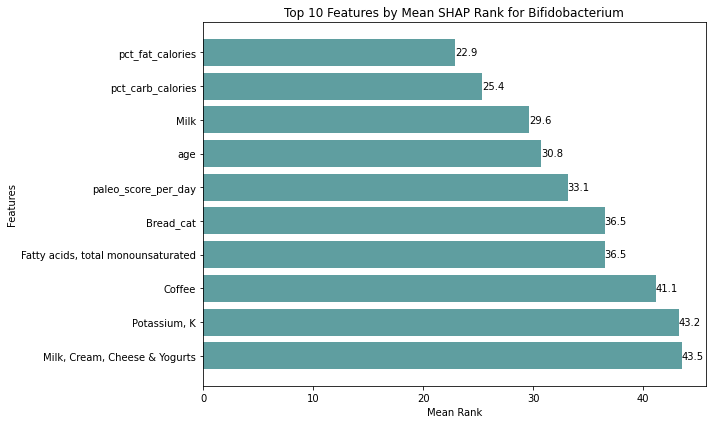

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,"Milk, Cream, Cheese & Yogurts",43.500,14.855855,3.0,54.0
1,"Potassium, K",43.250,37.583954,1.0,117.0
2,Coffee,41.125,52.579022,1.0,156.0
3,"Fatty acids, total monounsaturated",36.500,30.264312,1.0,84.0
4,Bread_cat,36.500,56.841729,2.0,148.0
5,paleo_score_per_day,33.125,50.253642,2.0,123.0
6,age,30.750,19.093754,17.0,76.0
7,Milk,29.625,52.097265,4.0,149.0
8,pct_carb_calories,25.375,41.729572,12.0,143.0
9,pct_fat_calories,22.875,38.921166,2.0,113.0


In [ ]:
analyze_genus_ranks("Bifidobacterium")


Ligilactobacillus ruminis
Lactococcus lactis


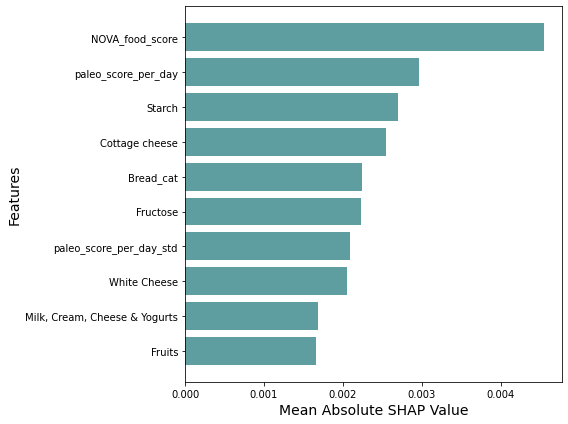

In [ ]:
analyze_genus('[Ll]acto')

Int64Index([43, 53], dtype='int64')
Ligilactobacillus ruminis
Lactococcus lactis


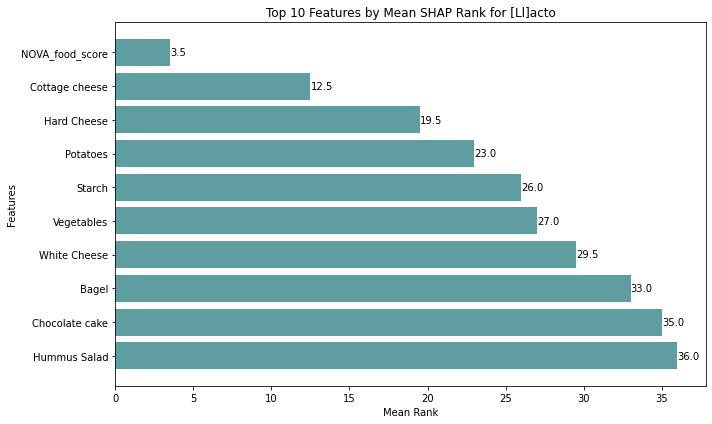

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Hummus Salad,36.0,3.535534,1.0,6.0
1,Chocolate cake,35.0,16.263456,1.0,24.0
2,Bagel,33.0,9.192388,13.0,26.0
3,White Cheese,29.5,0.000000,23.0,23.0
4,Vegetables,27.0,32.526912,3.0,49.0
5,Starch,26.0,2.828427,25.0,29.0
6,Potatoes,23.0,38.890873,2.0,57.0
7,Hard Cheese,19.5,8.485281,27.0,39.0
8,Cottage cheese,12.5,25.455844,17.0,53.0
9,NOVA_food_score,3.5,35.355339,11.0,61.0


In [ ]:
analyze_genus_ranks('[Ll]acto')

Int64Index([9, 10], dtype='int64')
Akkermansia muciniphila
Akkermansia massiliensis


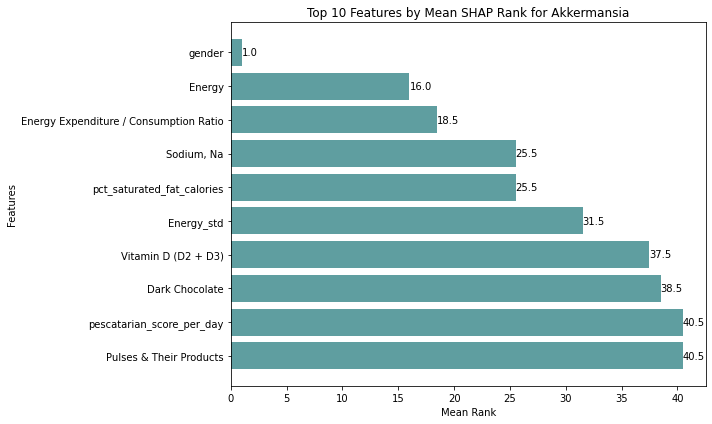

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Pulses & Their Products,40.5,0.000000,1.0,1.0
1,pescatarian_score_per_day,40.5,18.384776,3.0,29.0
2,Dark Chocolate,38.5,0.707107,18.0,19.0
3,Vitamin D (D2 + D3),37.5,14.849242,15.0,36.0
4,Energy_std,31.5,33.234019,2.0,49.0
5,pct_saturated_fat_calories,25.5,37.476659,5.0,58.0
6,"Sodium, Na",25.5,3.535534,35.0,40.0
7,Energy Expenditure / Consumption Ratio,18.5,43.133514,8.0,69.0
8,Energy,16.0,17.677670,28.0,53.0
9,gender,1.0,20.506097,26.0,55.0


In [ ]:
analyze_genus_ranks('Akkermansia')

Int64Index([46, 49, 48, 47, 51, 52, 50], dtype='int64')
Streptococcus thermophilus
Streptococcus salivarius
Streptococcus sp001556435
Streptococcus sp902463925
Streptococcus caecimuris
Streptococcus parasanguinis_C
Streptococcus parasanguinis


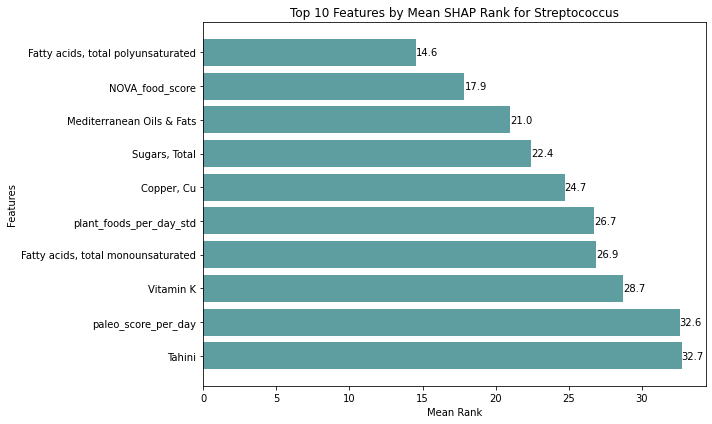

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Tahini,32.714286,13.648652,3.0,39.0
1,paleo_score_per_day,32.571429,41.522799,1.0,112.0
2,Vitamin K,28.714286,39.778554,3.0,111.0
3,"Fatty acids, total monounsaturated",26.857143,20.533364,6.0,64.0
4,plant_foods_per_day_std,26.714286,11.743286,8.0,42.0
5,"Copper, Cu",24.714286,17.717358,5.0,49.0
6,"Sugars, Total",22.428571,58.757776,1.0,160.0
7,Mediterranean Oils & Fats,21.000000,23.457154,11.0,73.0
8,NOVA_food_score,17.857143,26.550939,5.0,67.0
9,"Fatty acids, total polyunsaturated",14.571429,70.320017,3.0,192.0


In [ ]:
analyze_genus_ranks('Streptococcus')

Int64Index([481, 503, 491, 487, 494, 499, 484, 504, 486, 485, 492, 482, 502,
            495, 501, 493, 488, 490, 496, 500],
           dtype='int64')
Faecalibacterium sp900758465
Faecalibacterium sp900539885
Faecalibacterium prausnitzii_J
Faecalibacterium prausnitzii_E
Faecalibacterium prausnitzii
Faecalibacterium sp900539945
Faecalibacterium prausnitzii_I
Faecalibacterium sp900765105
Faecalibacterium hattorii
Faecalibacterium duncaniae
Faecalibacterium sp900772565
Faecalibacterium longum
Faecalibacterium prausnitzii_D
Faecalibacterium prausnitzii_A
Faecalibacterium prausnitzii_F
Faecalibacterium sp003449675
Faecalibacterium sp900765705
Faecalibacterium sp934503275
Faecalibacterium prausnitzii_A
Faecalibacterium sp902463905


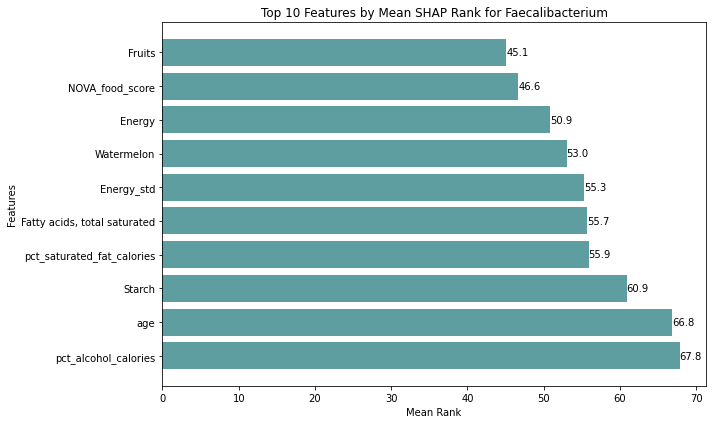

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,pct_alcohol_calories,67.85,41.215608,1.0,163.0
1,age,66.85,63.317309,1.0,258.0
2,Starch,60.90,53.488095,3.0,164.0
3,pct_saturated_fat_calories,55.90,72.476493,1.0,257.0
4,"Fatty acids, total saturated",55.70,52.248495,2.0,169.0
5,Energy_std,55.30,51.705746,3.0,176.0
6,Watermelon,53.00,52.968610,1.0,196.0
7,Energy,50.85,50.508884,1.0,181.0
8,NOVA_food_score,46.65,73.653009,2.0,216.0
9,Fruits,45.10,72.659462,1.0,248.0


In [ ]:
analyze_genus_ranks('Faecalibacterium')

Int64Index([667, 323, 674, 679, 672, 678, 671, 682, 683, 670, 665, 676, 681,
            680, 666, 687, 688, 668, 669, 689, 686, 685],
           dtype='int64')
Bacteroides cellulosilyticus
Bacteroides_F pectinophilus
Bacteroides uniformis
Bacteroides nordii
Bacteroides clarus
Bacteroides salyersiae
Bacteroides stercoris
Bacteroides thetaiotaomicron
Bacteroides zhangwenhongii
Bacteroides eggerthii
Bacteroides sp900552405
Bacteroides fragilis
Bacteroides faecis
Bacteroides bouchesdurhonensis
Bacteroides sp900759525
Bacteroides intestinigallinarum
Bacteroides ovatus
Bacteroides intestinalis
Bacteroides sp900556215
Bacteroides caccae
Bacteroides xylanisolvens
Bacteroides sp902362375


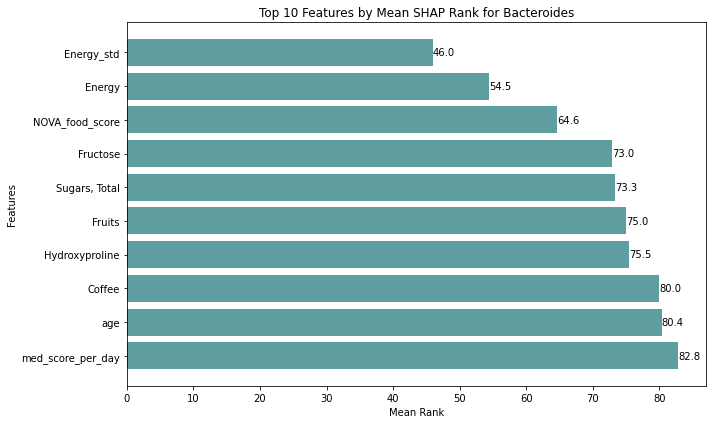

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,med_score_per_day,82.818182,49.579181,1.0,192.0
1,age,80.363636,65.907386,1.0,236.0
2,Coffee,80.000000,61.751930,1.0,168.0
3,Hydroxyproline,75.454545,77.365230,4.0,289.0
4,Fruits,74.954545,71.208872,1.0,259.0
5,"Sugars, Total",73.318182,80.201222,1.0,235.0
6,Fructose,72.954545,58.433297,5.0,217.0
7,NOVA_food_score,64.590909,68.233493,3.0,218.0
8,Energy,54.454545,102.881599,1.0,324.0
9,Energy_std,46.000000,63.580198,1.0,209.0


In [ ]:
analyze_genus_ranks('Bacteroides')

Int64Index([595,  46, 223,  34, 508,  32, 221, 309, 587, 237,
            ...
            648, 375,  36, 511, 170, 685, 348,  87, 292, 602],
           dtype='int64', length=681)
Lawsonibacter asaccharolyticus
Streptococcus thermophilus
UBA11774 sp003507655
Bifidobacterium longum
Ruthenibacterium lactatiformans
Bifidobacterium adolescentis
Pararoseburia lenta
Blautia_A sp000436615
Flavonifractor plautii
Agathobacter rectalis
Dysosmobacter welbionis
Alitiscatomonas aceti
Clostridium sp900539375
Negativibacillus sp000435195
Enterocloster sp900541315
unknown
Blautia_A fusiformis
Bifidobacterium bifidum
Dysosmobacter sp900544615
Spyradocola merdavium
Negativibacillus massiliensis
Alitiscatomonas sp900066055
Dorea_A longicatena
Alitiscatomonas sp900066785
Acidaminococcus intestini
COE1 sp001916965
F23-B02 sp001916715
Acetatifactor sp900755865
Mediterraneibacter torques
Anaerostipes hadrus
Bifidobacterium catenulatum
Bariatricus comes
Suilimivivens aceti
Avimicrobium caecorum
Hominenteromicr

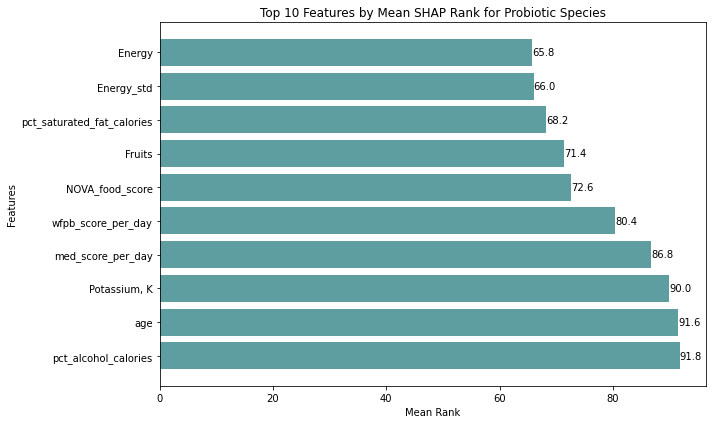

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,pct_alcohol_calories,91.781204,72.911390,1.0,315.0
1,age,91.556535,68.261640,1.0,334.0
2,"Potassium, K",89.972100,75.855980,1.0,314.0
3,med_score_per_day,86.794420,77.290863,1.0,299.0
4,wfpb_score_per_day,80.362702,78.797973,1.0,369.0
5,NOVA_food_score,72.634361,83.199684,1.0,347.0
6,Fruits,71.427313,83.725666,1.0,347.0
7,pct_saturated_fat_calories,68.170338,84.515318,1.0,355.0
8,Energy_std,66.038179,93.635574,1.0,375.0
9,Energy,65.787078,83.837311,1.0,335.0


In [ ]:
# Probiotic species
probiotics_pattern = (
    r'Bifidobacterium|'
    r'Streptococcus thermophilus|Streptococcus salivarius|'
    r'Akkermansia muciniphila|'
    r'Faecalibacterium prausnitzii|'
    r'Lactococcus lactis|'
    # r'Bacteroides'
)

# r'Bacteroides fragilis|Bacteroides vulgatus|': Two pathogenic bacteroides to remove if I include Bacteroides genus as probiotics.

analyze_genus_ranks(probiotics_pattern, title="Probiotic Species")

Int64Index([ 46,  34,  32,  33,  30,  28, 481,  43, 667, 323, 503, 491, 487,
             27,  53, 494,  29,   9, 674, 499, 679, 672,  49, 484, 504, 678,
             48, 486, 671, 485, 682, 492,  47, 482, 502, 683, 670, 665,  51,
             52, 495, 501, 493, 676, 681,  31, 680,  50, 666, 488,  10, 687,
            688, 668, 669, 490, 689, 686, 496, 500, 685],
           dtype='int64')
Streptococcus thermophilus
Bifidobacterium longum
Bifidobacterium adolescentis
Bifidobacterium bifidum
Bifidobacterium catenulatum
Bifidobacterium angulatum
Faecalibacterium sp900758465
Ligilactobacillus ruminis
Bacteroides cellulosilyticus
Bacteroides_F pectinophilus
Faecalibacterium sp900539885
Faecalibacterium prausnitzii_J
Faecalibacterium prausnitzii_E
Bifidobacterium animalis_B
Lactococcus lactis
Faecalibacterium prausnitzii
Bifidobacterium pseudocatenulatum
Akkermansia muciniphila
Bacteroides uniformis
Faecalibacterium sp900539945
Bacteroides nordii
Bacteroides clarus
Streptococcus salivarius
F

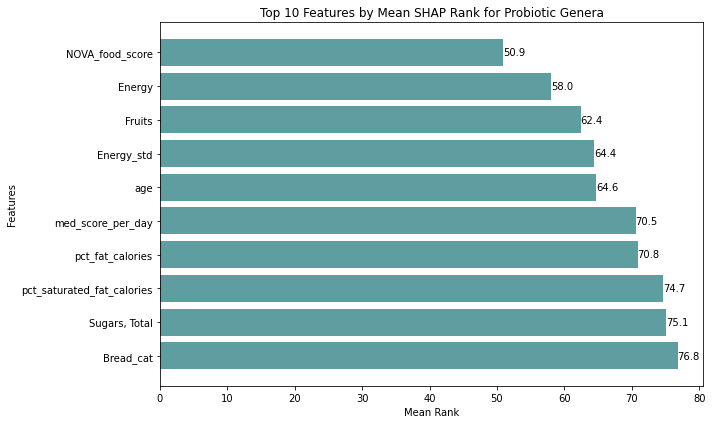

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Bread_cat,76.754098,63.956051,1.0,258.0
1,"Sugars, Total",75.065574,58.421883,1.0,250.0
2,pct_saturated_fat_calories,74.672131,61.152041,1.0,235.0
3,pct_fat_calories,70.836066,58.430950,1.0,292.0
4,med_score_per_day,70.524590,83.393452,1.0,324.0
5,age,64.639344,70.323445,1.0,289.0
6,Energy_std,64.393443,69.645814,1.0,256.0
7,Fruits,62.377049,75.041482,1.0,273.0
8,Energy,57.983607,68.885864,1.0,259.0
9,NOVA_food_score,50.918033,76.805307,2.0,291.0


In [ ]:
# Probiotic genera
probiotic_genera_pattern = (
    r'Bifidobacterium|'
    r'Streptococcus|'
    r'Akkermansia|'
    r'Faecalibacterium|'
    r'[Ll]acto|'
    r'Bacteroides'
)

analyze_genus_ranks(probiotic_genera_pattern, title="Probiotic Genera")

### Short Chain Fatty Acids producers

Int64Index([595, 272, 239, 230, 469, 319, 274, 472, 290, 291, 491, 487, 494,
            627, 233, 220, 484, 270, 470, 485, 216, 502, 271, 495, 501, 217,
            219, 628, 496],
           dtype='int64')
Lawsonibacter asaccharolyticus
Anaerostipes hadrus
Roseburia hominis
Roseburia inulinivorans
Butyricicoccus_A intestinisimiae
Eubacterium_G ventriosum
Anaerostipes amylophilus
Agathobaculum hominis
Eubacterium_I ramulus
Eubacterium_I ramulus_A
Faecalibacterium prausnitzii_J
Faecalibacterium prausnitzii_E
Faecalibacterium prausnitzii
Ruminococcus_E bromii_B
Roseburia intestinalis
Coprococcus sp000154245
Faecalibacterium prausnitzii_I
Anaerobutyricum soehngenii
Agathobaculum butyriciproducens
Faecalibacterium duncaniae
Coprococcus sp000433075
Faecalibacterium prausnitzii_D
Anaerobutyricum hallii
Faecalibacterium prausnitzii_A
Faecalibacterium prausnitzii_F
Coprococcus sp900548215
Coprococcus eutactus
Ruminococcus_E intestinalis
Faecalibacterium prausnitzii_A


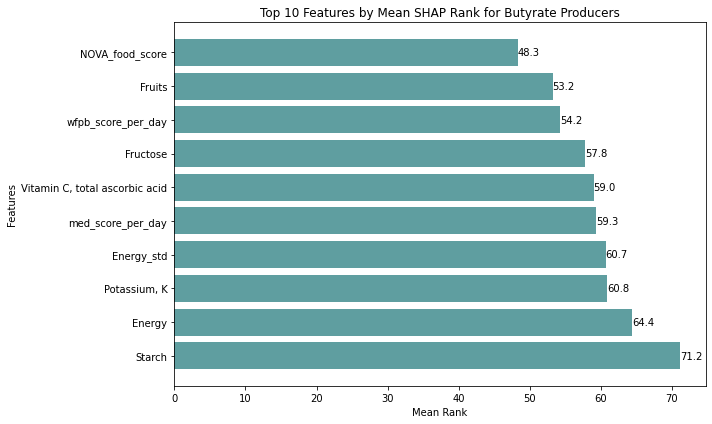

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Starch,71.172414,75.257784,1.0,283.0
1,Energy,64.448276,56.835841,1.0,257.0
2,"Potassium, K",60.827586,75.213342,1.0,275.0
3,Energy_std,60.655172,51.488604,3.0,175.0
4,med_score_per_day,59.275862,55.238110,1.0,187.0
5,"Vitamin C, total ascorbic acid",58.965517,76.839767,1.0,249.0
6,Fructose,57.827586,51.305302,2.0,177.0
7,wfpb_score_per_day,54.241379,67.883866,4.0,243.0
8,Fruits,53.206897,72.457173,2.0,265.0
9,NOVA_food_score,48.344828,77.353118,1.0,301.0


In [ ]:
butyrate_pattern = (
    r'Anaerobutyricum hallii|Anaerobutyricum soehngenii|'
    r'Anaerostipes hadrus|Anaerostipes amylophilus|'
    r'Agathobaculum butyriciproducens|Agathobaculum hominis|'
    r'Coprococcus eutactus|Coprococcus sp000154245|Coprococcus sp000433075|Coprococcus sp900548215|'
    r'Eubacterium_G ventriosum|Eubacterium_I ramulus|'
    r'Faecalibacterium prausnitzii|Faecalibacterium duncaniae|'
    r'Roseburia hominis|Roseburia intestinalis|Roseburia inulinivorans|'
    r'Ruminococcus_E bromii_B|Ruminococcus_E intestinalis|'
    r'Butyricicoccus_A intestinisimiae|Lawsonibacter asaccharolyticus'
)

analyze_genus_ranks(butyrate_pattern, title="Butyrate Producers")

Int64Index([ 46,  34,  32,  33, 239, 304, 319, 491, 487,  53, 494,   9, 160,
            233,  37, 484, 310, 432, 303, 682, 302, 502, 495, 501, 676, 219,
            688, 496],
           dtype='int64')
Streptococcus thermophilus
Bifidobacterium longum
Bifidobacterium adolescentis
Bifidobacterium bifidum
Roseburia hominis
Blautia_A wexlerae_C
Eubacterium_G ventriosum
Faecalibacterium prausnitzii_J
Faecalibacterium prausnitzii_E
Lactococcus lactis
Faecalibacterium prausnitzii
Akkermansia muciniphila
Phascolarctobacterium faecium
Roseburia intestinalis
Escherichia coli
Faecalibacterium prausnitzii_I
Blautia_A obeum
Collinsella bouchesdurhonensis
Blautia_A wexlerae
Bacteroides thetaiotaomicron
Blautia_A wexlerae_B
Faecalibacterium prausnitzii_D
Faecalibacterium prausnitzii_A
Faecalibacterium prausnitzii_F
Bacteroides fragilis
Coprococcus eutactus
Bacteroides ovatus
Faecalibacterium prausnitzii_A


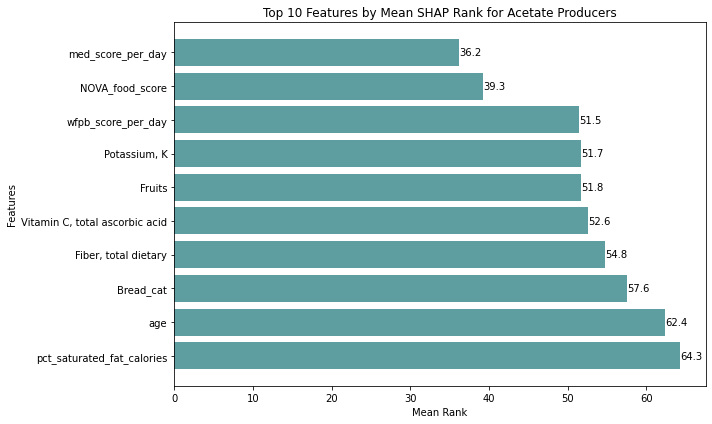

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,pct_saturated_fat_calories,64.321429,57.443727,1.0,249.0
1,age,62.428571,64.848460,1.0,258.0
2,Bread_cat,57.571429,70.117088,1.0,253.0
3,"Fiber, total dietary",54.785714,67.068708,4.0,266.0
4,"Vitamin C, total ascorbic acid",52.571429,58.266072,1.0,235.0
5,Fruits,51.750000,50.290584,3.0,174.0
6,"Potassium, K",51.714286,60.381109,1.0,250.0
7,wfpb_score_per_day,51.464286,60.506766,2.0,197.0
8,NOVA_food_score,39.285714,76.818414,1.0,248.0
9,med_score_per_day,36.178571,66.097601,2.0,241.0


In [ ]:
acetate_pattern = (
    r'Akkermansia muciniphila|'
    r'Bacteroides thetaiotaomicron|Bacteroides fragilis|Bacteroides ovatus|'
    r'Bifidobacterium adolescentis|Bifidobacterium bifidum|Bifidobacterium longum|'
    r'Blautia_A obeum|Blautia_A wexlerae|'
    r'Collinsella bouchesdurhonensis|'
    r'Coprococcus eutactus|'
    r'Eubacterium_G ventriosum|'
    r'Escherichia coli|'
    r'Faecalibacterium prausnitzii|'
    r'Lactococcus lactis|'
    r'Phascolarctobacterium faecium|'
    r'Roseburia hominis|Roseburia intestinalis|'
    r'Streptococcus thermophilus'
)

analyze_genus_ranks(acetate_pattern, title="Acetate Producers")

Int64Index([230, 166, 9, 381, 674, 160, 682, 676, 167, 219, 384, 162, 688,
            170],
           dtype='int64')
Roseburia inulinivorans
Dialister hominis
Akkermansia muciniphila
Prevotella copri_B
Bacteroides uniformis
Phascolarctobacterium faecium
Bacteroides thetaiotaomicron
Bacteroides fragilis
Dialister sp000434475
Coprococcus eutactus
Prevotella copri_A
Veillonella atypica
Bacteroides ovatus
Dialister sp900543455


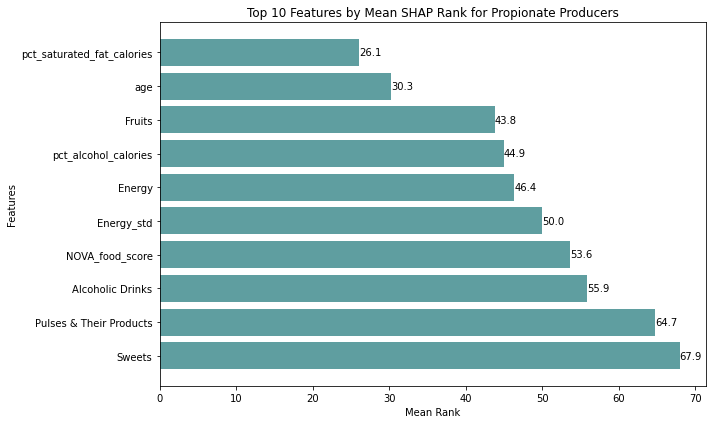

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Sweets,67.928571,52.947673,2.0,204.0
1,Pulses & Their Products,64.714286,49.381449,1.0,180.0
2,Alcoholic Drinks,55.857143,65.142658,3.0,235.0
3,NOVA_food_score,53.642857,52.976721,1.0,178.0
4,Energy_std,50.000000,70.089621,2.0,209.0
5,Energy,46.357143,51.190444,1.0,148.0
6,pct_alcohol_calories,44.928571,64.889975,3.0,223.0
7,Fruits,43.785714,53.181629,4.0,181.0
8,age,30.285714,73.858939,1.0,269.0
9,pct_saturated_fat_calories,26.071429,54.580166,9.0,180.0


In [ ]:
propionate_pattern = (
    r'Akkermansia muciniphila|'
    r'Bacteroides fragilis|Bacteroides thetaiotaomicron|Bacteroides ovatus|'
    r'Bacteroides vulgatus|Bacteroides uniformis|'
    r'Coprococcus eutactus|'
    r'Dialister hominis|Dialister sp000434475|Dialister sp900543455|'
    r'Phascolarctobacterium faecium|'
    r'Roseburia inulinivorans|'
    r'Prevotella copri|'
    r'Veillonella atypica'
)

analyze_genus_ranks(propionate_pattern, title="Propionate Producers")

Int64Index([ 34,  32,  33, 272, 239, 230, 304, 469, 319, 274, 472, 290, 291,
            491, 487,  53, 166, 494, 627, 381, 674, 160, 233, 220,  37, 484,
            270, 470, 310, 432, 303, 485, 216, 682, 302, 502, 271, 495, 501,
            676, 217, 167, 219, 384, 162, 688, 628, 496, 170],
           dtype='int64')
Bifidobacterium longum
Bifidobacterium adolescentis
Bifidobacterium bifidum
Anaerostipes hadrus
Roseburia hominis
Roseburia inulinivorans
Blautia_A wexlerae_C
Butyricicoccus_A intestinisimiae
Eubacterium_G ventriosum
Anaerostipes amylophilus
Agathobaculum hominis
Eubacterium_I ramulus
Eubacterium_I ramulus_A
Faecalibacterium prausnitzii_J
Faecalibacterium prausnitzii_E
Lactococcus lactis
Dialister hominis
Faecalibacterium prausnitzii
Ruminococcus_E bromii_B
Prevotella copri_B
Bacteroides uniformis
Phascolarctobacterium faecium
Roseburia intestinalis
Coprococcus sp000154245
Escherichia coli
Faecalibacterium prausnitzii_I
Anaerobutyricum soehngenii
Agathobaculum butyricipro

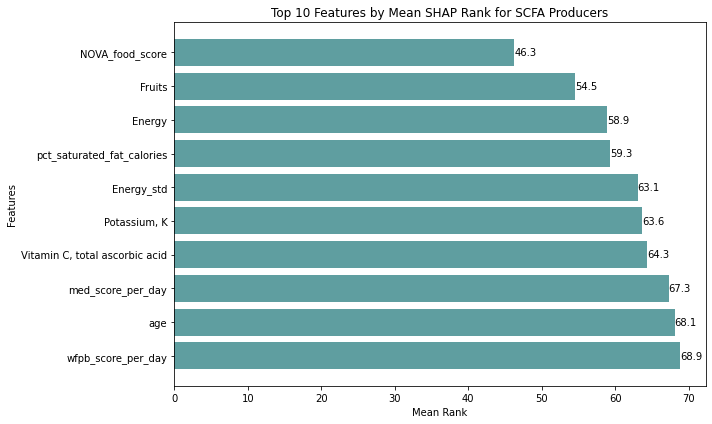

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,wfpb_score_per_day,68.877551,70.399751,1.0,283.0
1,age,68.102041,60.034054,1.0,257.0
2,med_score_per_day,67.285714,67.741926,2.0,265.0
3,"Vitamin C, total ascorbic acid",64.326531,67.737300,1.0,241.0
4,"Potassium, K",63.632653,51.592719,1.0,177.0
5,Energy_std,63.061224,68.537305,4.0,266.0
6,pct_saturated_fat_calories,59.306122,62.191367,1.0,270.0
7,Energy,58.897959,86.452299,1.0,315.0
8,Fruits,54.530612,87.364716,1.0,319.0
9,NOVA_food_score,46.285714,85.296940,1.0,286.0


In [ ]:
scfa_pattern = butyrate_pattern + acetate_pattern + propionate_pattern

analyze_genus_ranks(scfa_pattern, title="SCFA Producers")

### Disease promoting genera

Int64Index([422, 426, 423, 421], dtype='int64')
Desulfovibrio sp900556755
Desulfovibrio sp900319575
Desulfovibrio fairfieldensis
Desulfovibrio piger_A


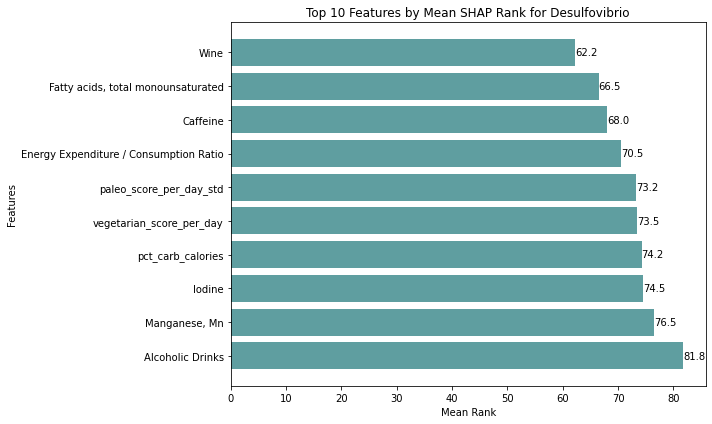

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Alcoholic Drinks,81.75,35.443617,32.0,110.0
1,"Manganese, Mn",76.50,26.789301,40.0,92.0
2,Iodine,74.50,43.787365,34.0,132.0
3,pct_carb_calories,74.25,70.410700,1.0,164.0
4,vegetarian_score_per_day,73.50,53.412701,16.0,143.0
5,paleo_score_per_day_std,73.25,75.852928,3.0,181.0
6,Energy Expenditure / Consumption Ratio,70.50,113.596875,4.0,244.0
7,Caffeine,68.00,80.185202,2.0,181.0
8,"Fatty acids, total monounsaturated",66.50,102.321389,3.0,227.0
9,Wine,62.25,88.001420,13.0,210.0


In [ ]:
analyze_genus_ranks('Desulfovibrio')

Int64Index([425, 594, 136, 696, 381, 160, 699,  37, 440,  55,  38,  73,  39,
             52, 676, 422, 426,  50, 423, 384, 162, 421],
           dtype='int64')
Bilophila wadsworthia
Lawsonibacter faecis
Odoribacter splanchnicus
Parabacteroides distasonis
Prevotella copri_B
Phascolarctobacterium faecium
Parabacteroides merdae
Escherichia coli
Eggerthella lenta
Holdemania filiformis
Klebsiella pneumoniae
Clostridium lentum
Enterobacter hormaechei_B
Streptococcus parasanguinis_C
Bacteroides fragilis
Desulfovibrio sp900556755
Desulfovibrio sp900319575
Streptococcus parasanguinis
Desulfovibrio fairfieldensis
Prevotella copri_A
Veillonella atypica
Desulfovibrio piger_A


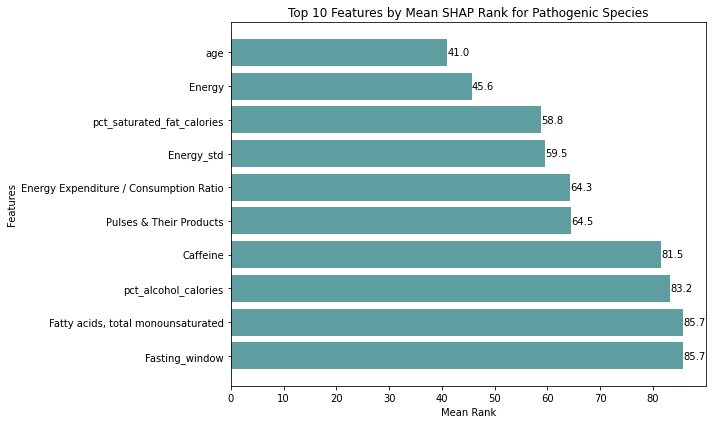

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,Fasting_window,85.681818,52.439968,1.0,206.0
1,"Fatty acids, total monounsaturated",85.681818,48.601926,2.0,171.0
2,pct_alcohol_calories,83.227273,75.885651,1.0,229.0
3,Caffeine,81.500000,54.772888,3.0,232.0
4,Pulses & Their Products,64.545455,52.561240,1.0,164.0
5,Energy Expenditure / Consumption Ratio,64.272727,75.004589,1.0,276.0
6,Energy_std,59.545455,58.216141,6.0,216.0
7,pct_saturated_fat_calories,58.818182,92.468750,2.0,266.0
8,Energy,45.636364,62.034849,5.0,263.0
9,age,41.045455,58.303301,4.0,174.0


In [ ]:
pathogenic_pattern = (
    r'Clostridium difficile|Clostridium perfringens|Clostridium septicum|'
    r'Clostridium sordellii|Clostridium botulinum|Clostridium tetani|'
    r'Escherichia coli|Enterotoxigenic E\. coli|Enteropathogenic E\. coli|'
    r'Enterohemorrhagic E\. coli|Enteroaggregative E\. coli|Uropathogenic E\. coli|'
    r'Enterobacter cloacae|Enterobacter aerogenes|Enterobacter hormaechei|'
    r'Klebsiella pneumoniae|Klebsiella oxytoca|'
    r'Proteus mirabilis|Proteus vulgaris|'
    r'Salmonella|'
    r'Shigella|'
    r'Campylobacter jejuni|Campylobacter coli|'
    r'Helicobacter pylori|Helicobacter hepaticus|'
    r'Fusobacterium nucleatum|Fusobacterium varium|'
    r'Bacteroides fragilis|Bacteroides vulgatus|'
    r'Bilophila wadsworthia|'
    r'Clostridium lentum|'
    r'Eggerthella lenta|'
    r'Holdemania filiformis|'
    r'Lawsonibacter faecis|'
    r'Methanobrevibacter smithii|'
    r'Odoribacter splanchnicus|'
    r'Parabacteroides distasonis|Parabacteroides merdae|'
    r'Phascolarctobacterium faecium|'
    r'Prevotella copri|'
    r'Ruminococcus gnavus|Ruminococcus torques|'
    r'Streptococcus gallolyticus|Streptococcus mutans|Streptococcus pyogenes|'
    r'Streptococcus parasanguinis|'
    r'Staphylococcus aureus|'
    r'Veillonella parvula|Veillonella atypica|'
    r'Morganella morganii|'
    r'Eubacterium rectale|'
    r'Hafnia alvei|'
    r'Pseudomonas aeruginosa|'
    r'Mycobacterium avium paratuberculosis|'
    r'Desulfovibrio'
)


analyze_genus_ranks(pathogenic_pattern, title="Pathogenic Species")

Int64Index([425, 37, 440, 38, 421], dtype='int64')
Bilophila wadsworthia
Escherichia coli
Eggerthella lenta
Klebsiella pneumoniae
Desulfovibrio piger_A


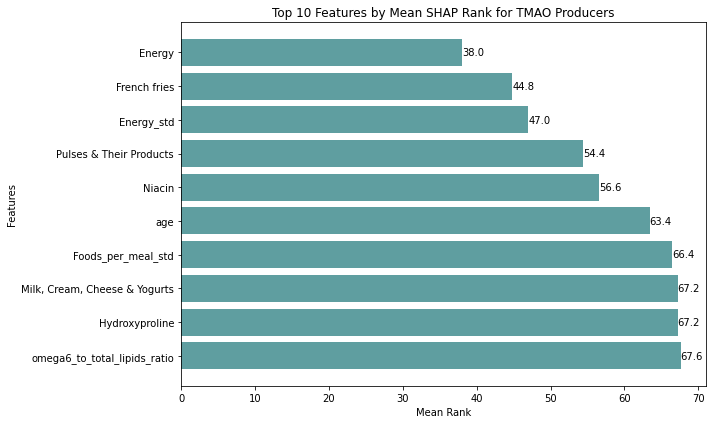

,Feature,Mean_Rank,Std_Rank,Min_Rank,Max_Rank
0,omega6_to_total_lipids_ratio,67.6,40.496913,7.0,89.0
1,Hydroxyproline,67.2,56.680685,16.0,146.0
2,"Milk, Cream, Cheese & Yogurts",67.2,35.839922,3.0,100.0
3,Foods_per_meal_std,66.4,56.460606,9.0,121.0
4,age,63.4,57.116548,9.0,150.0
5,Niacin,56.6,89.057846,1.0,206.0
6,Pulses & Their Products,54.4,68.182109,6.0,153.0
7,Energy_std,47.0,80.784900,25.0,211.0
8,French fries,44.8,69.833373,15.0,184.0
9,Energy,38.0,58.968636,27.0,165.0


In [ ]:
tmao_pattern = (
    r'Bilophila wadsworthia|'
    r'Desulfovibrio piger|'
    r'Escherichia coli|'
    r'Eggerthella lenta|'
    r'Klebsiella pneumoniae|'
    r'Proteus mirabilis|Proteus vulgaris|'
    r'Ruminococcus gnavus|'
    r'Salmonella'
)

analyze_genus_ranks(tmao_pattern, title="TMAO Producers")

### Noam's Plots - Finding Main Predictors

In [ ]:
mean_abs_shap_lgbm_abundance

,0,1,3,4,5,6,7,9,10,11,...,714,715,716,717,718,719,721,722,723,724
0,0.000005,0.000002,0.000020,1.111811e-05,0.000013,0.000062,0.000000,0.000007,0.001244,0.000036,...,0.000007,0.000000,0.000005,0.000000,0.000073,0.000000,0.000003,0.000009,0.000012,0.000003
1,0.000003,0.000007,0.000000,8.405643e-07,0.000007,0.000011,0.000018,0.000097,0.000000,0.000000,...,0.000007,0.000004,0.000016,0.000038,0.000000,0.000023,0.000000,0.000000,0.000005,0.000003
2,0.000065,0.000000,0.000023,9.938005e-05,0.000092,0.000000,0.000023,0.000045,0.000121,0.000013,...,0.000533,0.000003,0.000506,0.000096,0.000087,0.000105,0.000008,0.000122,0.000037,0.000195
3,0.000022,0.000000,0.000000,0.000000e+00,0.000020,0.000000,0.000000,0.000033,0.000004,0.000022,...,0.000000,0.000000,0.000000,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000,0.000020
4,0.000031,0.000000,0.000010,1.007767e-06,0.000048,0.000012,0.000007,0.000039,0.000661,0.000004,...,0.000208,0.000001,0.000007,0.000114,0.000009,0.000003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.000323,0.000056,0.016894,2.831540e-04,0.000631,0.001036,0.020895,0.040032,0.006758,0.000008,...,0.041127,0.000027,0.000678,0.030160,0.000027,0.000110,0.000004,0.000803,0.002483,0.000024
783,0.000007,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000008,0.000016,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000
784,0.000000,0.000000,0.000039,0.000000e+00,0.000000,0.000000,0.000031,0.000006,0.000015,0.000126,...,0.000013,0.000000,0.001944,0.000588,0.000060,0.000007,0.000014,0.000000,0.000115,0.000000
785,0.000105,0.000127,0.000883,9.911564e-05,0.000142,0.000252,0.000719,0.005414,0.000137,0.000063,...,0.000407,0.000100,0.002023,0.000404,0.002989,0.000103,0.000123,0.000444,0.000189,0.002081


Top 100 indices from lgbm_diet_scores: Int64Index([595,  46, 223,  34, 508,  32, 221, 309, 587, 237, 580, 201,  76,
            611, 203, 282, 297,  33, 574, 452, 612, 191, 284, 190, 155, 242,
            518, 246, 186, 272,  30, 280, 243, 512, 468, 575, 226, 610, 239,
             28, 609, 481, 458, 200, 225, 467, 446, 444, 230, 202, 585, 195,
            254, 304, 337, 231, 454, 279, 589, 469, 319, 116, 274, 588, 196,
            474, 718, 269, 584, 184, 255, 268, 294, 306, 576, 617,  99,  43,
            623, 472, 194, 238, 290, 197, 619, 667, 657, 152, 263,  93, 291,
            323, 590, 332, 425, 420, 503, 577, 491, 572],
           dtype='int64')
Subset of mean_abs_shap using top 100 indices:
           595        46       223        34       508        32       221  \
0    0.000051  0.000044  0.000088  0.000014  0.000013  0.000121  0.000017   
1    0.000020  0.000012  0.000143  0.000029  0.000057  0.000048  0.000021   
2    0.000016  0.000022  0.000084  0.000058  0.000108  0.00

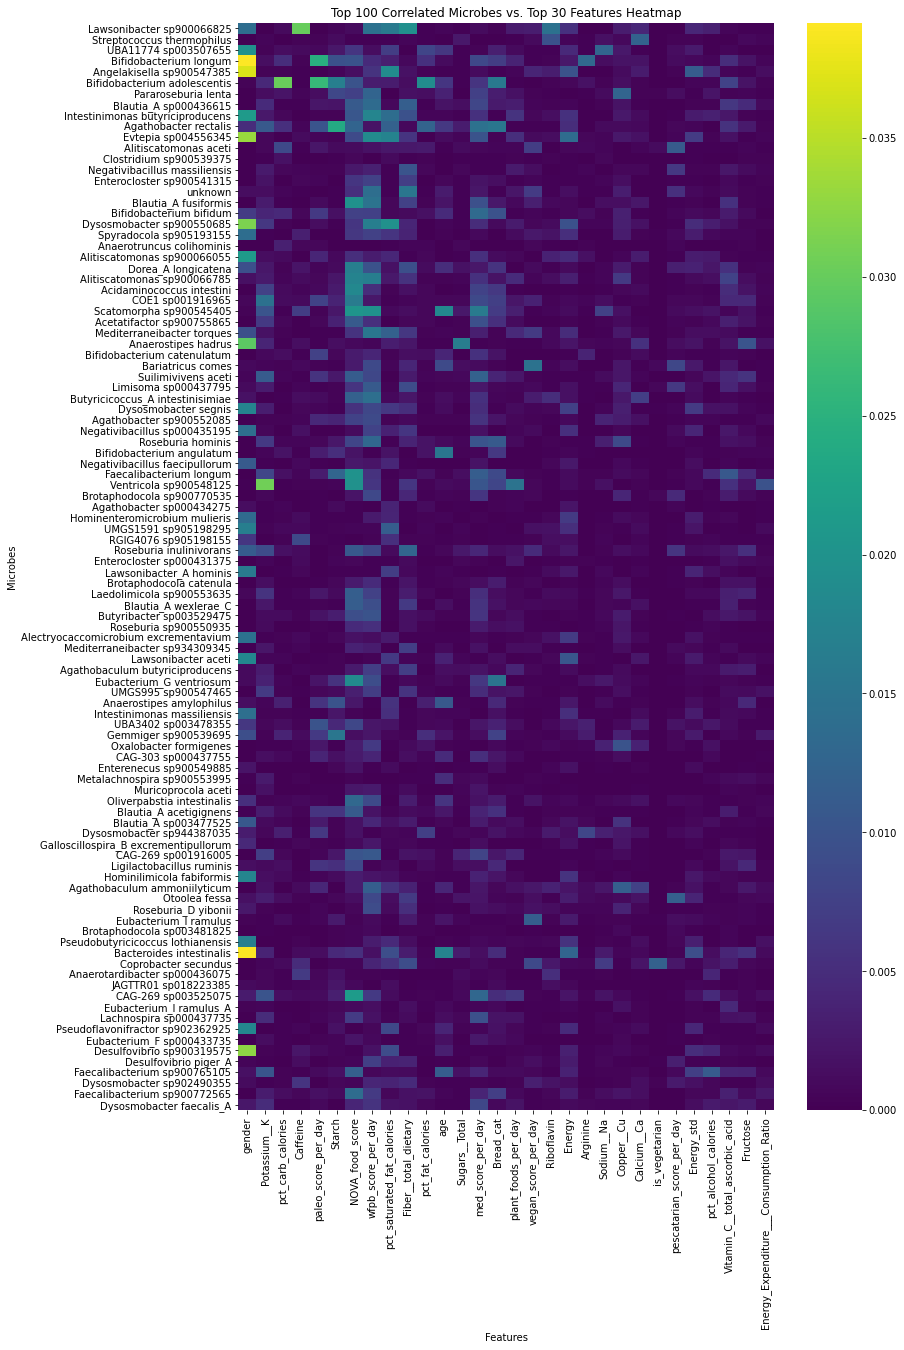

In [59]:
mean_abs_df = mean_abs_shap_lgbm_abundance_agg_regression


# Assume `mean_abs_shap` and `lgbm_diet_scores` DataFrames are already loaded

# Step 1: Extract the indices of the top 100 highest correlated microbes
top_100_indices = lgbm_diet_scores.sort_values(ascending=False)
top_100_indices = top_100_indices.head(100).index
print("Top 100 indices from lgbm_diet_scores:", top_100_indices)

# Step 2: Subset mean_abs_shap using these indices
# mean_abs_shap_top_100 = mean_abs_shap_lgbm_abundance.iloc[top_100_indices]
top_100_indices_str = [str(i) for i in top_100_indices]
mean_abs_shap_top_100 = mean_abs_df[top_100_indices_str]
print("Subset of mean_abs_shap using top 100 indices:\n", mean_abs_shap_top_100)

# selected_columns = (
#     mean_abs_shap_lgbm_abundance.max().nlargest(100).index
# )

# # Creating a new DataFrame with the selected columns
# mean_abs_shap_top_100 = mean_abs_shap_lgbm_abundance[selected_columns]
# print("Subset of mean_abs_shap using 100 microbes with highest max shap:\n", mean_abs_shap_top_100)

# Step 3: Identify the 30 features with the highest maximum mean_abs_shap values
# top_30_features = mean_abs_shap_lgbm_abundance.max().nlargest(30).index
top_30_features = mean_abs_shap_top_100.max(axis=1).nlargest(30).index
print("Top 30 features with highest max mean_abs_shap values:", top_30_features)

# Step 4: Subset the DataFrame to include only the selected features
# heatmap_data = mean_abs_shap_top_100[top_30_features]
heatmap_data = mean_abs_shap_top_100.iloc[top_30_features]
print("Final heatmap data shape:", heatmap_data.shape)
print("Sample of heatmap data:\n", heatmap_data.head())

# Step 5: Rename the axis labels
heatmap_data = heatmap_data.T
# Replace x-axis (columns) with corresponding feature names
heatmap_data.columns = [all_features[int(i)] for i in top_30_features]

# Replace y-axis (rows) with corresponding target names
heatmap_data.index = [mb_names.loc[targets[int(i)], 'species_new'] for i in top_100_indices]


print("Updated column labels (features):", heatmap_data.columns.tolist())
print("Updated row labels (targets):", heatmap_data.index.tolist())

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, cmap="viridis", annot=False)
plt.title("Top 100 Correlated Microbes vs. Top 30 Features Heatmap")
plt.xlabel("Features")
plt.ylabel("Microbes")
plt.savefig(home + f"figures/{PROBLEM}/shap_main_predictors_mean_abs{aggregation}.png", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()


Top 100 indices from lgbm_diet_scores: Int64Index([595,  46, 223,  34, 508,  32, 221, 309, 587, 237, 580, 201,  76,
            611, 203, 282, 297,  33, 574, 452, 612, 191, 284, 190, 155, 242,
            518, 246, 186, 272,  30, 280, 243, 512, 468, 575, 226, 610, 239,
             28, 609, 481, 458, 200, 225, 467, 446, 444, 230, 202, 585, 195,
            254, 304, 337, 231, 454, 279, 589, 469, 319, 116, 274, 588, 196,
            474, 718, 269, 584, 184, 255, 268, 294, 306, 576, 617,  99,  43,
            623, 472, 194, 238, 290, 197, 619, 667, 657, 152, 263,  93, 291,
            323, 590, 332, 425, 420, 503, 577, 491, 572],
           dtype='int64')
Subset of mean_abs_shap using top 100 indices:
           595        46       223        34       508        32       221  \
0    0.000000  0.000005  0.000008  0.000000  0.000007  0.000000  0.000012   
1    0.000000  0.000004  0.000006  0.000004  0.000002  0.000007  0.000006   
2    0.000006  0.000009  0.000076  0.000072  0.000078  0.00

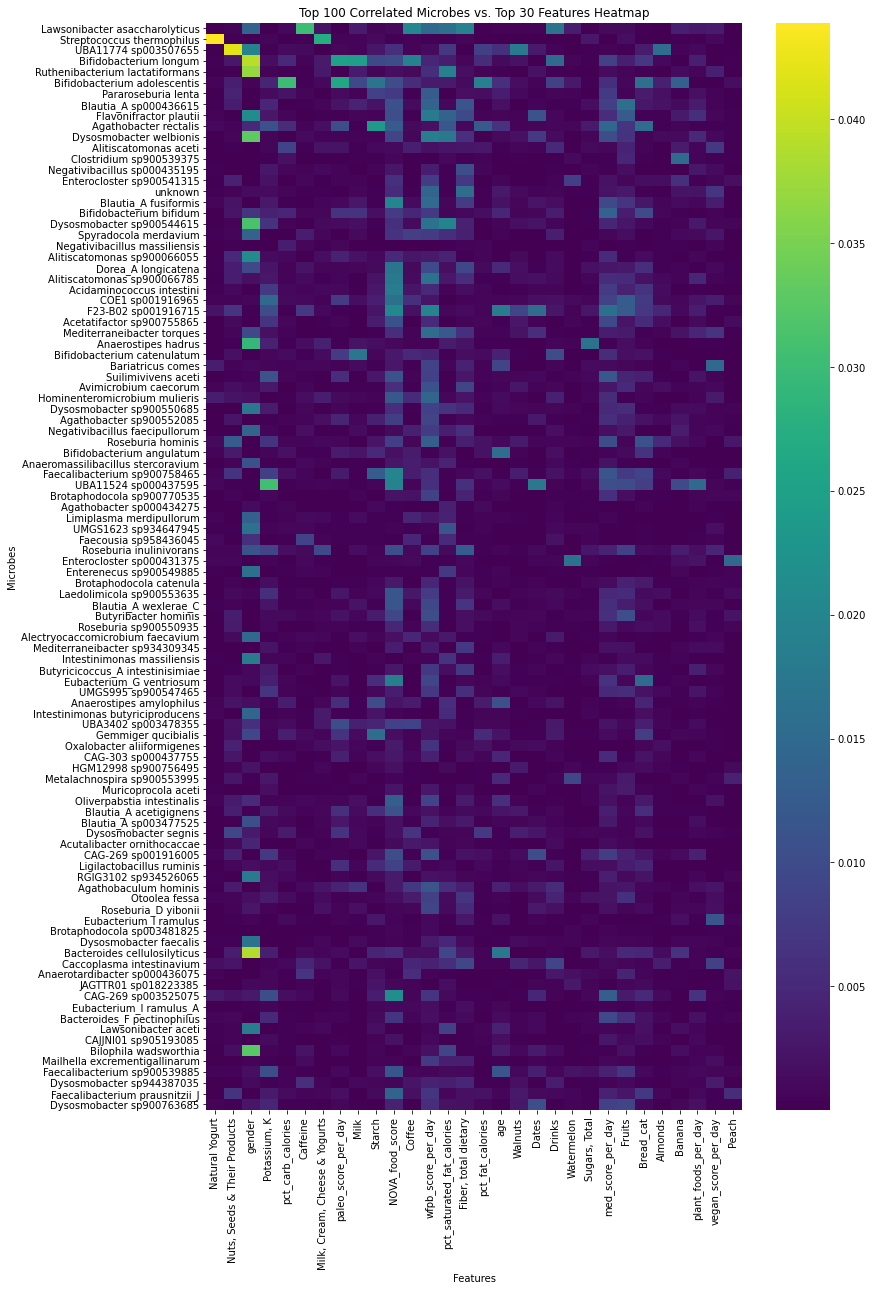

In [ ]:
mean_abs_df = mean_abs_shap_lgbm_abundance


# Assume `mean_abs_shap` and `lgbm_diet_scores` DataFrames are already loaded

# Step 1: Extract the indices of the top 100 highest correlated microbes
top_100_indices = lgbm_diet_scores.sort_values(ascending=False)
top_100_indices = top_100_indices.head(100).index
print("Top 100 indices from lgbm_diet_scores:", top_100_indices)

# Step 2: Subset mean_abs_shap using these indices
# mean_abs_shap_top_100 = mean_abs_shap_lgbm_abundance.iloc[top_100_indices]
top_100_indices_str = [str(i) for i in top_100_indices]
mean_abs_shap_top_100 = mean_abs_df[top_100_indices_str]
print("Subset of mean_abs_shap using top 100 indices:\n", mean_abs_shap_top_100)

# selected_columns = (
#     mean_abs_shap_lgbm_abundance.max().nlargest(100).index
# )

# # Creating a new DataFrame with the selected columns
# mean_abs_shap_top_100 = mean_abs_shap_lgbm_abundance[selected_columns]
# print("Subset of mean_abs_shap using 100 microbes with highest max shap:\n", mean_abs_shap_top_100)

# Step 3: Identify the 30 features with the highest maximum mean_abs_shap values
# top_30_features = mean_abs_shap_lgbm_abundance.max().nlargest(30).index
top_30_features = mean_abs_shap_top_100.max(axis=1).nlargest(30).index
print("Top 30 features with highest max mean_abs_shap values:", top_30_features)

# Step 4: Subset the DataFrame to include only the selected features
# heatmap_data = mean_abs_shap_top_100[top_30_features]
heatmap_data = mean_abs_shap_top_100.iloc[top_30_features]
print("Final heatmap data shape:", heatmap_data.shape)
print("Sample of heatmap data:\n", heatmap_data.head())

# Step 5: Rename the axis labels
heatmap_data = heatmap_data.T
# Replace x-axis (columns) with corresponding feature names
heatmap_data.columns = [all_features[int(i)] for i in top_30_features]

# Replace y-axis (rows) with corresponding target names
heatmap_data.index = [mb_names.loc[targets[int(i)], 'species_new'] for i in top_100_indices]


print("Updated column labels (features):", heatmap_data.columns.tolist())
print("Updated row labels (targets):", heatmap_data.index.tolist())

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, cmap="viridis", annot=False)
plt.title("Top 100 Correlated Microbes vs. Top 30 Features Heatmap")
plt.xlabel("Features")
plt.ylabel("Microbes")
plt.savefig(home + f"figures/{PROBLEM}/shap_main_predictors_mean_abs{aggregation}.png", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()
